<a href="https://colab.research.google.com/github/rlagosb/GastricCancerIncidence/blob/main/3_Analisis_Estimaciones_Chile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducción
Este notebook presenta el análisis de la incidencia de cáncer gástrico estimada en el notebook anterior, utilizando datos de población y cobertura de salud de varias provincias y regiones. El objetivo es identificar patrones, generar clusters de provincias basadas en su riesgo y características sociodemográficas, y modelar la incidencia a lo largo del tiempo. Los métodos incluyen:

1.  **Carga y preparación de datos:** Se cargan y procesan datos de incidencia, población estándar de la OMS, y división política administrativa de Chile.
2.  **Tablas de resumen:** Se crean tablas que resumen la incidencia cruda y estandarizada por sexo y periodo, así como por provincia y periodo.
3.  **Clustering de provincias:** Se utiliza el algoritmo K-Means para agrupar provincias en clusters de riesgo (bajo, medio, alto) basándose en la incidencia, ruralidad y cobertura de salud (Isapre).
4.  **Visualizaciones cartográficas:** Se generan mapas de calor para visualizar la incidencia, ruralidad y cobertura de Isapre por macrorregión y por periodos de tiempo.
5.  **Series de tiempo:** Se analizan las tendencias temporales de la incidencia estratificada por sexo, edad y clusters de riesgo.
6.  **Modelos mixtos:** Se ajustan modelos de regresión lineal mixtos para evaluar el efecto de covariables como la edad, el sexo, la ruralidad y la cobertura de salud en la incidencia, considerando la variabilidad entre provincias.

# Setup 💾

In [1]:
# Importar librerías
import pandas as pd
import geopandas as gpd
import numpy as np
import plotly.express as px
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, mannwhitneyu, norm, t, skewnorm, kstest
import requests
import os

# Carpetas de origen y destino
path_data='https://raw.githubusercontent.com/rlagosb/GastricCancerIncidence/main/Data/'
path_output = '/content/output/'

# Nro de habitantes para calcular tasas
HABS = 100000

## Cargar datos

In [2]:
# Cargar Periodos
periodos_xl = pd.read_excel(path_data + 'Parametros_estimaciones.xlsx', sheet_name='Periodos RPC', header=1)
def cargar_periodos_rpc(df):
  df = (df.rename(columns={'ID':'Año'}).
        melt(id_vars='Año', value_name='Periodo', var_name='Provincia').
        dropna(subset='Periodo'))
  for col in df.columns: df[col] = df[col].astype(int)
  return df
periodos = cargar_periodos_rpc(periodos_xl)
periodos

# Mostrar periodos (Provincia 1000 es para estimaciones nacionales, el resto para calibración)
periodos.pivot(index='Año', columns='Provincia', values='Periodo').astype('Int64').fillna(0)

Provincia,21,22,23,71,72,73,74,81,83,141,142,151,1000
Año,,,,,,,,,,,,,
2003,2005,2005,2005,0,0,0,0,0,2004,2004,2004,0,2004
2004,2005,2005,2005,0,0,0,0,0,2004,2004,2004,0,2004
2005,2005,2005,2005,0,0,0,0,0,2004,2004,2004,0,2004
2006,2005,2005,2005,0,0,0,0,2007,2007,2007,2007,0,2007
2007,2008,2008,2008,0,0,0,0,2007,2007,2007,2007,0,2007
2008,2008,2008,2008,0,0,0,0,2007,2007,2007,2007,2010,2007
2009,2008,2008,2008,0,0,0,0,2010,2010,2010,2010,2010,2011
2010,2011,2011,2011,0,0,0,0,2010,2010,2010,2010,2010,2011
2011,2011,2011,2011,0,0,0,0,2010,2010,2010,2010,2010,2011


In [3]:
# cargar datos

cubo = pd.read_parquet(path_data + 'CUBO_CANCER_DIGESTIVO.parquet')[lambda x: x.Provincia!=122] # filtrar provincia Antártica=122
cubo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22176 entries, 0 to 22967
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Provincia             22176 non-null  int64  
 1   Nombre Provincia      22176 non-null  object 
 2   Nombre Region         22176 non-null  object 
 3   Region                22176 non-null  int64  
 4   Macrorregion          22176 non-null  object 
 5   Año                   22176 non-null  int64  
 6   Codigo                22176 non-null  int64  
 7   Sexo                  22176 non-null  object 
 8   RangoEdad10           22176 non-null  object 
 9   RangoEdad4080         22176 non-null  object 
 10  MedianaRangoEdad10    22176 non-null  float64
 11  MedianaRangoEdad4080  22176 non-null  float64
 12  Poblacion             22176 non-null  int64  
 13  PoblacionRural        22176 non-null  int64  
 14  A                     22176 non-null  int64  
 15  B                     22

In [4]:
# Fuente: https://seer.cancer.gov/stdpopulations/world.who.html

poblacion_estandar = (pd.read_excel(path_data + 'Parametros_estimaciones.xlsx', sheet_name='Poblacion_OMS').drop(columns=['Age']).
                      pivot_table(index=['RangoEdad4080'], values='PoblacionOMS', aggfunc='sum', margins=True).reset_index())
print(poblacion_estandar)

  RangoEdad4080  PoblacionOMS
0       [0, 40)        655070
1      [40, 50)        126256
2      [50, 60)         99165
3      [60, 70)         66777
4      [70, 80)         37287
5     [80, 120)         15445
6           All       1000000


### Cargar División Política Administrativa (PROVINCIAS) de Chile
Fuente: [Geoportal de Chile](https://geoportal.cl/geoportal/catalog/36391/Divisi%C3%B3n%20Pol%C3%ADtica%20Administrativa%202023)

In [6]:
url_origen = 'https://www.geoportal.cl/geoportal/catalog/download/912598ad-ac92-35f6-8045-098f214bd9c2'
# Ruta donde se guardará el archivo en el directorio /content/
output_filename = '/content/DPA_2023.zip'
# Descargar el archivo
response = requests.get(url_origen)
# Verificar que la descarga fue exitosa
if response.status_code == 200:
    with open(output_filename, 'wb') as f:
        f.write(response.content)
    print(f'Archivo descargado exitosamente')
else:
    print(f'Error al descargar el archivo. Código de estado: {response.status_code}')

Archivo descargado exitosamente


In [7]:
# Extract only the 'PROVINCIAS' folder from DPA_2023.zip to /content/PROVINCIAS_only
!unzip /content/DPA_2023.zip "PROVINCIAS/*" -d /content/
# List the contents of the newly extracted folder
!ls -R /content/PROVINCIAS

Archive:  /content/DPA_2023.zip
 extracting: /content/PROVINCIAS/PROVINCIAS_v1.cpg  
  inflating: /content/PROVINCIAS/PROVINCIAS_v1.dbf  
  inflating: /content/PROVINCIAS/PROVINCIAS_v1.prj  
  inflating: /content/PROVINCIAS/PROVINCIAS_v1.shp  
  inflating: /content/PROVINCIAS/PROVINCIAS_v1.shx  
/content/PROVINCIAS:
PROVINCIAS_v1.cpg  PROVINCIAS_v1.prj  PROVINCIAS_v1.shx
PROVINCIAS_v1.dbf  PROVINCIAS_v1.shp


In [8]:
# Extraer geometrías de Provincias
prov_gpd = (gpd.read_file('PROVINCIAS/PROVINCIAS_v1.shp').
            rename(columns={'CUT_PROV':'Provincia', 'CUT_REG':'Region'}))
prov_gpd.Provincia = prov_gpd.Provincia.astype(int)
# add centroid of each Provincia
prov_gpd['centroid_x'] = prov_gpd.geometry.centroid.x
prov_gpd['centroid_y'] = prov_gpd.geometry.centroid.y

prov_gpd.info()

/tmp/ipython-input-3059742288.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  prov_gpd['centroid_x'] = prov_gpd.geometry.centroid.x
/tmp/ipython-input-3059742288.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  prov_gpd['centroid_y'] = prov_gpd.geometry.centroid.y


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Region      56 non-null     object  
 1   Provincia   56 non-null     int64   
 2   REGION      56 non-null     object  
 3   PROVINCIA   56 non-null     object  
 4   SUPERFICIE  56 non-null     float64 
 5   geometry    56 non-null     geometry
 6   centroid_x  56 non-null     float64 
 7   centroid_y  56 non-null     float64 
dtypes: float64(3), geometry(1), int64(1), object(3)
memory usage: 3.6+ KB


## Funciones

In [9]:
#@title Cargar Estimaciones

def cargar_predicciones(**kwargs):
  predicciones = pd.read_parquet(path_data + 'Predicciones.parquet')

  # filtra predicciones por variables que se pasan en kwargs (ejemplo: Metodo=RIMcl)
  for variable, valor in kwargs.items():
    try:
      filtro = (predicciones[variable]==valor)
      predicciones = predicciones[filtro]
    except: print('No se encontró parámetro: '+variable)
  return predicciones

# Predicciones para Chile
inc = cargar_predicciones(Escenario='Chile', Grupo='Testing')
print(inc.info())
inc.sample(3)

<class 'pandas.core.frame.DataFrame'>
Index: 27720 entries, 0 to 5039
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   RangoEdad4080     27720 non-null  object 
 1   Nombre Provincia  27720 non-null  object 
 2   Provincia         27720 non-null  int64  
 3   Sexo              27720 non-null  object 
 4   Periodo           27720 non-null  int64  
 5   Categoria         27720 non-null  object 
 6   Ratio             27720 non-null  object 
 7   RatioEst          27720 non-null  float64
 8   IncidenciaObs     2880 non-null   float64
 9   IncidenciaEst     27720 non-null  float64
 10  Poblacion         27720 non-null  int64  
 11  Metodo            27720 non-null  object 
 12  Escenario         27720 non-null  object 
 13  Grupo             27720 non-null  object 
dtypes: float64(3), int64(3), object(8)
memory usage: 3.2+ MB
None


,RangoEdad4080,Nombre Provincia,Provincia,Sexo,Periodo,Categoria,Ratio,RatioEst,IncidenciaObs,IncidenciaEst,Poblacion,Metodo,Escenario,Grupo
629,"[40, 50)",San Antonio,56,Hombre,2014,C16,RIM,0.676354,NaN,13.268956,33428,RIMcovscl,Chile,Testing
1009,"[50, 60)",General Carrera,114,Hombre,2011,C16,RIMH,1.113178,NaN,84.748007,2120,RIMHcl,Chile,Testing
4001,"[60, 70)",Bíobío,83,Mujer,2014,C16,RIMH,1.120165,50.979393,63.014708,51001,RIMHcl,Chile,Testing


In [10]:
#@title Calcular incidencia provincias

def calcular_incidencia_provincias(dataInc, niveles=None):

  # calcular casos
  dataInc['Casos'] = dataInc.IncidenciaEst * dataInc.Poblacion / HABS

  # agregar casos al nivel definido
  niveles += ['Periodo']
  dataInc = (dataInc.groupby(niveles)[['Casos','Poblacion']].sum())

  # calcular incidencia
  dataInc['IncidenciaEst'] = dataInc.Casos / dataInc.Poblacion * HABS

  return dataInc.reset_index()

calcular_incidencia_provincias(inc.copy(), niveles=['Metodo','Sexo']).\
pivot(index='Periodo', columns=['Metodo','Sexo'], values='IncidenciaEst').tail(5)

Metodo       RIHcl             RIHcovscl                RIMHcl             \
Sexo        Hombre      Mujer     Hombre      Mujer     Hombre      Mujer   
Periodo                                                                     
2011     30.566573  15.308619  30.621023  15.217837  29.756682  15.398470   
2014     29.846928  15.056455  32.149221  16.096804  28.693202  15.087435   
2017     29.633902  14.819190  34.194945  16.949994  28.163339  14.466225   
2020     25.882998  13.032341  31.872027  15.930650  24.995529  13.078210   
2023     27.063597  13.931840  35.455673  18.108332  25.263033  13.552866   

Metodo  RIMHcovscl                 RIMcl             RIMcovscl             
Sexo        Hombre      Mujer     Hombre      Mujer     Hombre      Mujer  
Periodo                                                                    
2011     29.877267  15.321903  31.353138  14.996250  31.414031  14.922517  
2014     30.655542  15.973206  29.913957  14.400244  29.919984  14.307031  
2017     31.866928  16.221344  28.412186  13.457339  28.672078  13.632917  
2020     29.851082  15.492628  25.603964  12.322883  25.815689  12.498210  
2023     31.724523  16.884644  24.423506  12.037156  24.593561  12.194947


Mann-Whitney U Test Statistic: 731.000, p-value: 0.166
Shapiro-Wilk Test Statistic : 0.967, p-value: 0.371
Kolmogorov-Smirnov Test Statistic : 0.109, p-value: 0.764
Normal distribution fit: mu = 0.173, std = 2.858


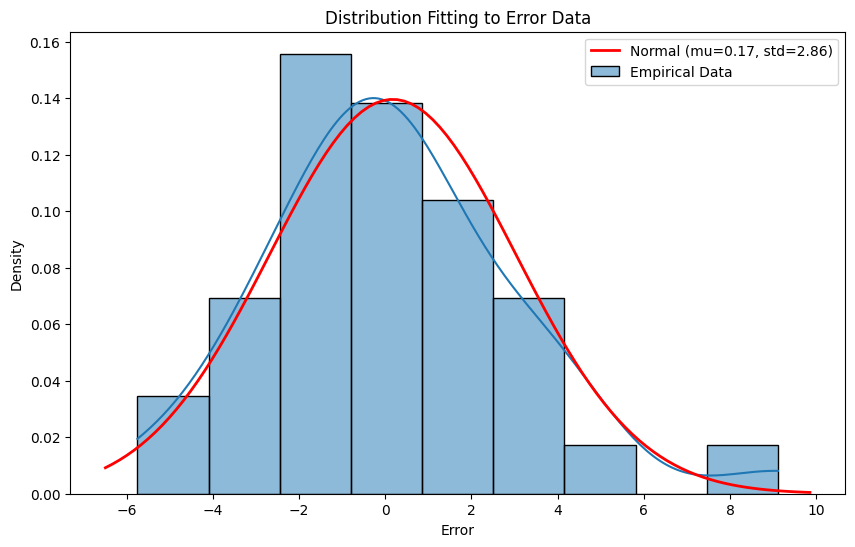

In [11]:
#@title Cálculo Errores

def cargar_errores_incidencia_periodos():

  # Cargar errores de la VALIDACIÓN CRUZADA (not Escenario1) (por eso los valores son diferentes al ejemplo del notebook 2)
  inc = cargar_predicciones(Metodo='RIM', Grupo='Testing')[lambda x: ~x.Escenario.isin(['Escenario1','Chile'])]
  inc['CasosEst'] = inc.IncidenciaEst * inc.Poblacion / HABS
  inc['CasosObs'] = inc.IncidenciaObs * inc.Poblacion / HABS

  # Evaluar diferencia de error por Sexo
  inc2 = inc.groupby(['Provincia','Sexo','Periodo'])[['CasosEst','CasosObs','Poblacion']].sum().reset_index()
  inc2['IncidenciaEst'] = inc2.CasosEst / inc2.Poblacion * HABS
  inc2['IncidenciaObs'] = inc2.CasosObs / inc2.Poblacion * HABS
  inc2['Error'] = (inc2.IncidenciaEst - inc2.IncidenciaObs)
  # Perform Mann-Whitney U test to compare error distributions between sexes
  error_hombre = inc2[inc2.Sexo == 'Hombre']['Error']
  error_mujer = inc2[inc2.Sexo == 'Mujer']['Error']
  stat, p_value = mannwhitneyu(error_hombre, error_mujer)
  print(f'\nMann-Whitney U Test Statistic: {stat:.3f}, p-value: {p_value:.3f}')

  # Evaluar normalidad de error provincial
  inc = inc.groupby(['Provincia','Periodo'])[['CasosEst','CasosObs','Poblacion']].sum().reset_index()
  inc['IncidenciaEst'] = inc.CasosEst / inc.Poblacion * HABS
  inc['IncidenciaObs'] = inc.CasosObs / inc.Poblacion * HABS
  inc['Error'] = (inc.IncidenciaEst - inc.IncidenciaObs)
  # Perform Shapiro-Wilk test for normality
  stat_shapiro, p_value_shapiro = shapiro(inc['Error'])
  print(f'Shapiro-Wilk Test Statistic : {stat_shapiro:.3f}, p-value: {p_value_shapiro:.3f}')

  # Perform Kolmogorov-Smirnov test for normality
  stat_kstest, p_value_kstest = kstest(inc['Error'], 'norm', args=(inc['Error'].mean(), inc['Error'].std()))
  print(f'Kolmogorov-Smirnov Test Statistic : {stat_kstest:.3f}, p-value: {p_value_kstest:.3f}')

  # Fit Normal distribution
  mu, std = norm.fit(inc['Error'])
  print(f"Normal distribution fit: mu = {mu:.3f}, std = {std:.3f}")

  # Visualize the fitted distributions
  plt.figure(figsize=(10, 6))
  sns.histplot(inc['Error'], kde=True, stat="density", label="Empirical Data")

  xmin, xmax = plt.xlim()
  x = np.linspace(xmin, xmax, 100)

  p_norm = norm.pdf(x, mu, std)
  plt.plot(x, p_norm, 'r', linewidth=2, label=f'Normal (mu={mu:.2f}, std={std:.2f})')

  plt.title("Distribution Fitting to Error Data")
  plt.xlabel("Error")
  plt.ylabel("Density")
  plt.legend()
  plt.show()

  return std

normal_std_error = cargar_errores_incidencia_periodos()

Since this p-value (0.371) is greater than the typical significance level of 0.05, we fail to reject the null hypothesis. This means that, based on the Shapiro-Wilk test, there is not enough statistical evidence to conclude that the 'Error' data is not normally distributed.

The Mann-Whitney U Test Statistic: since the p-value (0.166) is greater than the typical significance level of 0.05, we fail to reject the null hypothesis. This suggests there is no statistically significant difference in the distribution of errors between the 'Hombre' and 'Mujer' groups.

# 🔰Incidencia Estudio/Objetivo

## Tabla 2: Incidencia cruda y estandarizada
Tasas cruda y estandarizada de incidencia de CG
- Columnas: Población de estudio original y población objetivo
- Filas: tasa de incidencia, tasa de mortalidad, tasa de egresos, tasa de egresos+defunciones combinada, ratios
- Celdas: Promedio (desviación estándar)


In [12]:
def cargar_poblaciones_tabla23(periodo_objetivo=range(2003,2025)):

  # cargar predicciones de incidencia con RIM
  df = cargar_predicciones(Ratio='RIM')[lambda x: ((x.Escenario.isin(['Chile','Escenario1']) & (x.Metodo.isin(['RIMcl','RIM']))))]
  df['Grupo'] = df['Escenario'].map({'Chile':'Objetivo','Escenario1':'Estudio'})
  print(df[['Grupo','Escenario']].value_counts(dropna=False))
  # Agregar años
  df_objetivo = df[df.Grupo=='Objetivo'].merge(periodos[periodos.Provincia==1000][['Año','Periodo']], on='Periodo')
  df_estudio = df[df.Grupo=='Estudio'].merge(periodos, on=['Periodo','Provincia'])
  df = pd.concat([df_objetivo,df_estudio])

  # Cruzar con cubo
  df = (df.drop(columns=['Nombre Provincia','Poblacion']). # botar columnas repetidas
        merge(cubo, on=['Año','Provincia','Sexo','RangoEdad4080','Categoria']))

  # Calcular casos
  df['Casos'] = df.Poblacion * df.IncidenciaEst / HABS


  return df

poblaciones_tabla23 = cargar_poblaciones_tabla23()
poblaciones_tabla23.info()

Grupo     Escenario 
Objetivo  Chile         4620
Estudio   Escenario1     420
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24156 entries, 0 to 24155
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   RangoEdad4080         24156 non-null  object 
 1   Provincia             24156 non-null  int64  
 2   Sexo                  24156 non-null  object 
 3   Periodo               24156 non-null  int64  
 4   Categoria             24156 non-null  object 
 5   Ratio                 24156 non-null  object 
 6   RatioEst              24156 non-null  float64
 7   IncidenciaObs         4284 non-null   float64
 8   IncidenciaEst         24156 non-null  float64
 9   Metodo                24156 non-null  object 
 10  Escenario             24156 non-null  object 
 11  Grupo                 24156 non-null  object 
 12  Año                   24156 non-null  int64  
 13  Nombre Provincia

In [13]:
def cargar_tasas_tabla2_sexo(df):

  # Calcular numeradores para tasas estandarizadas a nivel nacional
  numeradores = ['Casos','Defunciones','Egresos2', 'EgresosDefs']
  numeradoresPob = numeradores + ['Poblacion']

  # Agregar a nivel nacional por sexo, edad y grupo estudio/objetivo
  df = (df.groupby(['Grupo','Sexo','RangoEdad4080','Año'])[numeradoresPob].sum().reset_index().
        merge(poblacion_estandar, on='RangoEdad4080', how='left')) # agregar población estándar
  for num in numeradores:
    df[num+'OMS'] = (df[num]/df.Poblacion) * df.PoblacionOMS

  # Agregar a nivel de población estudio/objetivo y sexo
  df = (df.groupby(['Grupo','Sexo'])[numeradoresPob + [num+'OMS' for num in numeradoresPob]].sum().reset_index())

  # Agregar total por poblacion
  totals = df.groupby(['Grupo'])[numeradoresPob + [num+'OMS' for num in numeradoresPob]].sum().reset_index()
  totals['Sexo'] = 'Total'
  df = pd.concat([df,totals])

  # Calcular tasas crudas y estandarizadas (Std)
  tasas = ['Incidencia','Mortalidad','Hospitalizaciones','HospDefunciones']
  for tasa, numerador in dict(zip(tasas, numeradores)).items():
    df[tasa] = (df[numerador] / df.Poblacion * HABS)
    df[tasa+'Std'] = (df[numerador+'OMS'] / df.PoblacionOMS * HABS)

  # Tasas como filas
  df = (df.melt(id_vars=['Grupo','Sexo'],
             value_vars=tasas + [tasa +'Std' for tasa in tasas],
             var_name='Tasa', value_name='Valor').
        sort_values(by='Sexo').
        pivot(index='Tasa',columns=['Sexo','Grupo'],values='Valor').
        round(1).reset_index())

  # Ordenar tabla
  df['Tipo'] = 'Cruda'
  df.loc[df.Tasa.str.contains('Std'),'Tipo'] = 'Estándar'
  df = df.sort_values(by='Tipo').set_index(['Tipo','Tasa'])

  return df

cargar_tasas_tabla2_sexo(poblaciones_tabla23.copy())

Sexo                           Hombre            Mujer            Total  \
Grupo                         Estudio Objetivo Estudio Objetivo Estudio   
Tipo     Tasa                                                             
Cruda    HospDefunciones         37.3     32.2    18.1     16.9    27.7   
         Hospitalizaciones       25.3     21.1    11.9     10.8    18.5   
         Incidencia              33.7     28.8    15.1     13.8    24.3   
         Mortalidad              27.9     24.0    12.7     11.7    20.3   
Estándar HospDefuncionesStd      37.3     30.5    14.8     12.7    26.0   
         HospitalizacionesStd    24.6     19.8    10.0      8.5    17.3   
         IncidenciaStd           33.1     27.1    12.0     10.2    22.6   
         MortalidadStd           27.8     22.7     9.9      8.5    18.8   

Sexo                                    
Grupo                         Objetivo  
Tipo     Tasa                           
Cruda    HospDefunciones          24.4  
         Hospitalizaciones        15.9  
         Incidencia               21.2  
         Mortalidad               17.8  
Estándar HospDefuncionesStd       21.6  
         HospitalizacionesStd     14.2  
         IncidenciaStd            18.7  
         MortalidadStd            15.6

## Tabla 3: Incidencia cruda por provincia-periodo

In [14]:
def cargar_tasas_tabla3(df):

  # Calcular total nacional
  nac = (df[df.Grupo=='Objetivo'].
        groupby(['Periodo'])[['Casos','Poblacion']].sum().reset_index())
  nac['Nombre Region'] = 'Nacional'
  nac['Nombre Provincia'] = 'Nacional'

  # Calcular  casos y pob por provincia y agregar total nacional
  df = (df[df.Grupo=='Objetivo'].
        groupby(['Nombre Region','Nombre Provincia','Periodo'])[['Casos','Poblacion']].sum().reset_index())
  df = pd.concat([df,nac])

  # Calcular incidencia cruda
  df['Incidencia'] = (df.Casos / df.Poblacion * HABS)

  df = (df.pivot_table(index=['Nombre Region','Nombre Provincia'],
                      columns='Periodo',
                      values='Incidencia',
                      aggfunc='mean').round(1).
        loc[['Arica y Parinacota', 'Tarapacá', 'Antofagasta', 'Atacama', 'Coquimbo', 'Valparaíso', 'Metropolitana de Santiago', 'Libertador General Bernardo O\'Higgins', 'Maule', 'Ñuble', 'Biobío', 'La Araucanía', 'Los Ríos', 'Los Lagos',
             'Aysén del General Carlos Ibáñez del Campo', 'Magallanes y de la Antártica Chilena', 'Nacional']])

  return df

tasasProvPeriodo = cargar_tasas_tabla3(poblaciones_tabla23.copy())
tasasProvPeriodo

Periodo                                                     2004  2007  2011  \
Nombre Region                             Nombre Provincia                     
Arica y Parinacota                        Arica             18.3  16.4  14.2   
                                          Parinacota         0.0  13.6   0.0   
Tarapacá                                  Iquique           15.1  14.5  17.1   
                                          Tamarugal          6.6  11.3   4.3   
Antofagasta                               Antofagasta       15.9  14.8  13.8   
                                          El Loa             8.7  14.2  10.8   
                                          Tocopilla         23.0  10.5  21.9   
Atacama                                   Chañaral          12.8  23.1  14.6   
                                          Copiapó           13.0  13.8  13.0   
                                          Huasco            23.4  23.6  21.6   
Coquimbo                                  Choapa            30.2  29.8  25.2   
                                          Elqui             19.7  19.2  18.6   
                                          Limarí            23.6  28.9  27.2   
Valparaíso                                Isla de Pascua     0.0   8.5   9.3   
                                          Los Andes         20.1  17.4  21.8   
                                          Marga Marga       27.2  26.1  26.2   
                                          Petorca           30.8  26.7  31.4   
                                          Quillota          30.2  24.1  25.0   
                                          San Antonio       31.4  33.3  28.9   
                                          San Felipe        18.8  22.5  18.4   
                                          Valparaíso        25.4  24.2  26.8   
Metropolitana de Santiago                 Chacabuco         16.2  11.4  15.3   
                                          Cordillera        12.0  13.6  15.7   
                                          Maipo             20.4  18.1  18.7   
                                          Melipilla         20.0  21.6  23.9   
                                          Santiago          19.5  18.7  19.2   
                                          Talagante         19.7  20.2  17.6   
Libertador General Bernardo O'Higgins     Cachapoal         20.6  18.1  19.6   
                                          Cardenal Caro     19.2  28.2  23.7   
                                          Colchagua         34.9  24.4  24.0   
Maule                                     Cauquenes         33.3  43.8  33.2   
                                          Curicó            35.6  31.3  29.9   
                                          Linares           31.9  34.0  32.5   
                                          Talca             35.5  27.7  26.1   
Ñuble                                     Diguillín         28.5  29.0  27.2   
                                          Itata             44.4  34.8  49.3   
                                          Punilla           38.1  30.6  31.3   
Biobío                                    Arauco            28.8  36.4  37.2   
                                          Bíobío            32.2  31.7  36.3   
                                          Concepción        25.8  25.2  27.7   
La Araucanía                              Cautín            28.2  29.8  30.8   
                                          Malleco           40.2  36.1  38.0   
Los Ríos                                  Ranco             23.0  33.8  36.3   
                                          Valdivia          33.7  26.2  32.4   
Los Lagos                                 Chiloé            23.9  23.4  24.6   
                                          Llanquihue        22.0  22.8  25.4   
                                          Osorno            30.2  34.0  30.2   
                                          Palena             8.7  31.2  35.3   


In [15]:
tasasProvPeriodo_with_ci = tasasProvPeriodo.copy()

for periodo in tasasProvPeriodo_with_ci.columns:
    # Extract the mean and standard deviation for the current sex
    mean_incidence = tasasProvPeriodo_with_ci[periodo]

    # Calculate the confidence interval using the function
    # Periodo 2011 tiene 4 años
    ci_lower = mean_incidence - 1.96 * normal_std_error * (np.sqrt(3/4) if periodo == '2011' else 1)
    ci_upper = mean_incidence + 1.96 * normal_std_error * (np.sqrt(3/4) if periodo == '2011' else 1)

    # Add the confidence intervals to the DataFrame
    tasasProvPeriodo_with_ci[('Lower_CI', periodo)] = np.maximum(ci_lower, 0) # truncate in 0
    tasasProvPeriodo_with_ci[('Upper_CI', periodo)] = ci_upper


# Format the output to display mean (Lower_CI-Upper_CI)
formatted_columns = {}
for col in tasasProvPeriodo.columns:
    formatted_columns[col] = tasasProvPeriodo_with_ci.apply(
        lambda row: f"{row[col]:.1f} ({row[('Lower_CI', col)]:.1f}-{row[('Upper_CI', col)]:.1f})", axis=1)

formatted_tasasProvPeriodo = pd.DataFrame(formatted_columns, index=tasasProvPeriodo_with_ci.index)
formatted_tasasProvPeriodo.columns = ['2003-2005','2006-2008','2009-2012','2013-2015','2016-2018','2019-2021','2022-2024']
# Display the formatted DataFrame
display(formatted_tasasProvPeriodo)

2003-2005  \
Nombre Region                             Nombre Provincia                     
Arica y Parinacota                        Arica             18.3 (12.7-23.9)   
                                          Parinacota           0.0 (0.0-5.6)   
Tarapacá                                  Iquique            15.1 (9.5-20.7)   
                                          Tamarugal           6.6 (1.0-12.2)   
Antofagasta                               Antofagasta       15.9 (10.3-21.5)   
                                          El Loa              8.7 (3.1-14.3)   
                                          Tocopilla         23.0 (17.4-28.6)   
Atacama                                   Chañaral           12.8 (7.2-18.4)   
                                          Copiapó            13.0 (7.4-18.6)   
                                          Huasco            23.4 (17.8-29.0)   
Coquimbo                                  Choapa            30.2 (24.6-35.8)   
                                          Elqui             19.7 (14.1-25.3)   
                                          Limarí            23.6 (18.0-29.2)   
Valparaíso                                Isla de Pascua       0.0 (0.0-5.6)   
                                          Los Andes         20.1 (14.5-25.7)   
                                          Marga Marga       27.2 (21.6-32.8)   
                                          Petorca           30.8 (25.2-36.4)   
                                          Quillota          30.2 (24.6-35.8)   
                                          San Antonio       31.4 (25.8-37.0)   
                                          San Felipe        18.8 (13.2-24.4)   
                                          Valparaíso        25.4 (19.8-31.0)   
Metropolitana de Santiago                 Chacabuco         16.2 (10.6-21.8)   
                                          Cordillera         12.0 (6.4-17.6)   
                                          Maipo             20.4 (14.8-26.0)   
                                          Melipilla         20.0 (14.4-25.6)   
                                          Santiago          19.5 (13.9-25.1)   
                                          Talagante         19.7 (14.1-25.3)   
Libertador General Bernardo O'Higgins     Cachapoal         20.6 (15.0-26.2)   
                                          Cardenal Caro     19.2 (13.6-24.8)   
                                          Colchagua         34.9 (29.3-40.5)   
Maule                                     Cauquenes         33.3 (27.7-38.9)   
                                          Curicó            35.6 (30.0-41.2)   
                                          Linares           31.9 (26.3-37.5)   
                                          Talca             35.5 (29.9-41.1)   
Ñuble                                     Diguillín         28.5 (22.9-34.1)   
                                          Itata             44.4 (38.8-50.0)   
                                          Punilla           38.1 (32.5-43.7)   
Biobío                                    Arauco            28.8 (23.2-34.4)   
                                          Bíobío            32.2 (26.6-37.8)   
                                          Concepción        25.8 (20.2-31.4)   
La Araucanía                              Cautín            28.2 (22.6-33.8)   
                                          Malleco           40.2 (34.6-45.8)   
Los Ríos                                  Ranco             23.0 (17.4-28.6)   
                                          Valdivia          33.7 (28.1-39.3)   
Los Lagos                                 Chiloé            23.9 (18.3-29.5)   
                                          Llanquihue        22.0 (16.4-27.6)   
                                          Osorno            30.2 (24.6-35.8)   
                                          Palena              8.7 (3.1-14.3)   
Aysén del General Carlos Ibáñez del Campo Aysén              12.9 (

**Note** 📌

The distribution of the **4-year average incidence** is still a **Normal Distribution**. Its parameters (mean and variance) can be expressed in terms of the 3-year average's parameters by factoring in the change in the number of years.

Let's define the parameters based on the original variables:

| Parameter | Annual Incidence ($X_i$) | 3-Year Average Incidence ($Y_3$) |
| :--- | :--- | :--- |
| **Mean** | $\mu$ | $\mu_{Y_3} = \mu$ |
| **Variance** | $\sigma^2$ | $\sigma^2_{Y_3} = \frac{\sigma^2}{3}$ |

***

**1. Mean of the 4-Year Average**

The mean of the 4-year average ($\mu_{Y_4}$) is the same as the mean of the 3-year average ($\mu_{Y_3}$), as both are unbiased estimators of the true annual mean incidence ($\mu$).

$$\mu_{Y_4} = \mu_{Y_3}$$

**2. Variance of the 4-Year Average**

The variance of an average is inversely proportional to the number of observations (years). The core relationship is:
$$\text{Var}(\text{Average over } n \text{ years}) = \frac{\sigma^2}{n}$$

We need to express $\sigma^2$ (the unknown annual variance) in terms of the known 3-year variance ($\sigma^2_{Y_3}$).

From the 3-year average:
$$\sigma^2_{Y_3} = \frac{\sigma^2}{3}$$
Solving for $\sigma^2$:
$$\sigma^2 = 3 \cdot \sigma^2_{Y_3}$$

Now, substitute this expression for $\sigma^2$ into the formula for the 4-year variance ($\sigma^2_{Y_4}$):

$$\sigma^2_{Y_4} = \frac{\sigma^2}{4} = \frac{3 \cdot \sigma^2_{Y_3}}{4}$$

***

**Summary of the 4-Year Distribution**

The distribution of the 4-year average incidence ($Y_4$) is **Normal** with parameters expressed as follows:

$$Y_4 \sim N\left(\mu_{Y_3}, \frac{3}{4} \cdot \sigma^2_{Y_3}\right)$$

In words: The 4-year average incidence has the **same mean** as the 3-year average, but its **variance is 3/4 (or 75%) of the variance** of the 3-year average. This reduced variance reflects the increased precision gained by averaging over a longer period.

In [ ]:
#@title Material sup 4: Incidencia cruda por provincia y sexo

def cargar_tasas_tabla3(df):

  nac = (df[df.Grupo=='Objetivo'].
        groupby(['Sexo','Periodo'])[['Casos','Poblacion']].sum().reset_index())
  nac['Nombre Region'] = 'Nacional'
  nac['Nombre Provincia'] = 'Nacional'

  df = (df[df.Grupo=='Objetivo'].
        groupby(['Nombre Region','Nombre Provincia','Sexo','Periodo'])[['Casos','Poblacion']].sum().reset_index())

  df = pd.concat([df,nac])

  df['Incidencia'] = (df.Casos / df.Poblacion * HABS)

  df = (df.pivot_table(index=['Nombre Region','Nombre Provincia'],
                      columns=['Sexo','Periodo'],
                      values='Incidencia',
                      aggfunc='mean',
                      margins=True, margins_name='Total').round(1).drop('Total').
        loc[['Arica y Parinacota', 'Tarapacá', 'Antofagasta', 'Atacama', 'Coquimbo', 'Valparaíso', 'Metropolitana de Santiago', 'Libertador General Bernardo O\'Higgins', 'Maule', 'Ñuble', 'Biobío', 'La Araucanía', 'Los Ríos', 'Los Lagos',
             'Aysén del General Carlos Ibáñez del Campo', 'Magallanes y de la Antártica Chilena', 'Nacional']])

  return df

tasasProv = cargar_tasas_tabla3(poblaciones_tabla23.copy())
tasasProv

/tmp/ipython-input-2948406911.py:21: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



Sexo                                                       Hombre              \
Periodo                                                      2004  2007  2011   
Nombre Region                             Nombre Provincia                      
Arica y Parinacota                        Arica              25.4  23.8  19.6   
                                          Parinacota          0.0   0.0   0.0   
Tarapacá                                  Iquique            20.2  16.4  23.6   
                                          Tamarugal          12.5  15.1   5.6   
Antofagasta                               Antofagasta        21.6  21.0  19.1   
                                          El Loa             13.8  20.8  13.2   
                                          Tocopilla          36.4  16.2  31.6   
Atacama                                   Chañaral           15.7  34.2  24.3   
                                          Copiapó            20.0  16.6  16.1   
                                          Huasco             30.8  28.8  29.4   
Coquimbo                                  Choapa             45.3  41.0  29.2   
                                          Elqui              25.0  25.4  23.6   
                                          Limarí             29.3  34.8  37.0   
Valparaíso                                Isla de Pascua      0.0   0.0   0.0   
                                          Los Andes          26.1  24.2  29.2   
                                          Marga Marga        35.1  33.9  35.7   
                                          Petorca            52.3  37.0  44.6   
                                          Quillota           41.9  36.1  33.5   
                                          San Antonio        46.0  49.5  38.1   
                                          San Felipe         21.7  27.6  28.4   
                                          Valparaíso         33.8  31.8  35.5   
Metropolitana de Santiago                 Chacabuco          25.8  17.1  22.5   
                                          Cordillera         16.5  17.6  19.8   
                                          Maipo              25.2  24.6  26.2   
                                          Melipilla          30.9  32.0  34.5   
                                          Santiago           25.1  25.3  25.5   
                                          Talagante          25.9  30.5  25.6   
Libertador General Bernardo O'Higgins     Cachapoal          27.7  25.4  26.3   
                                          Cardenal Caro      27.2  36.8  39.5   
                                          Colchagua          49.6  35.2  33.9   
Maule                                     Cauquenes          46.2  57.5  50.6   
                                          Curicó             50.1  44.4  42.2   
                                          Linares            44.3  50.5  45.6   
                                          Talca              47.7  38.8  34.3   
Ñuble                                     Diguillín          43.2  37.5  36.9   
                                          Itata              71.5  51.8  72.8   
                                          Punilla            55.4  42.7  51.3   
Biobío                                    Arauco             38.5  52.8  55.0   
                                          Bíobío             44.9  46.3  52.0   
                                          Concepción         36.1  33.2  38.0   
La Araucanía                              Cautín             38.5  40.9  42.0   
                                          Malleco            58.3  49.4  54.6   
Los Ríos                                  Ranco              31.8  47.3  52.0   
                                          Valdivia           44.3  37.8  44.5   
Los Lagos                                 Chiloé             29.9  28.8  29.1   
                                          Llanquihue         30.6  31.6  33.4   
                               

# 🎨 Clusters de Incidencia
Generate three clusters of Provincias using k-means on the coverage data from the `clusters_cobertura_Fonasa` function

In [16]:
# Prepare data for clustering

def data_clusters_cobertura_Fonasa():
  tramos = ['A','B','C','D','Isapre']
  df = (cubo[cubo.Categoria=='C16'].
        groupby(['Provincia','Nombre Provincia','Año'])[tramos+['Poblacion','PoblacionRural']].sum().reset_index())
  for col in tramos:
    df['cob'+col] = df[col] / df.Poblacion * 100
  df['Ruralidad'] = df.PoblacionRural / df.Poblacion * 100
  # Cobertura promedio por provincia
  df = df.groupby(['Provincia','Nombre Provincia'])[['cob'+col for col in tramos]+['Ruralidad']].mean().reset_index()

  # Calculate average incidence per province
  average_incidence_province = calcular_incidencia_provincias(inc, niveles=['Provincia']).groupby('Provincia')['IncidenciaEst'].mean().reset_index()
  # Merge with cobertura_df
  df = df.merge(average_incidence_province, on='Provincia', how='left')

  return df


cobertura_df = data_clusters_cobertura_Fonasa()
cobertura_df

,Provincia,Nombre Provincia,cobA,cobB,cobC,cobD,cobIsapre,Ruralidad,IncidenciaEst
0,11,Iquique,21.440918,22.430296,13.057651,16.665088,21.682806,1.543295,12.601673
1,14,Tamarugal,30.142458,20.937893,11.715244,16.399999,5.711763,48.704900,8.156794
2,21,Antofagasta,13.687941,19.916517,12.478700,18.492878,30.781706,2.288786,13.907667
3,22,El Loa,12.264881,19.912350,12.808984,21.954240,36.718190,4.894511,10.870275
4,23,Tocopilla,15.987702,12.539938,7.443971,11.581060,24.199447,4.489715,16.081027
5,31,Copiapó,18.855249,23.897332,13.552777,21.614661,17.054382,4.279307,15.208785
6,32,Chañaral,16.663257,20.763383,14.532030,23.352344,30.358607,7.937009,17.477138
7,33,Huasco,22.998173,26.086685,13.135962,20.544004,11.595500,19.820377,20.672365
8,41,Elqui,19.074295,27.199968,14.007349,18.465011,12.561374,10.902064,18.184379
9,42,Choapa,24.414540,26.681965,11.007950,15.453633,5.112475,37.052692,20.717431


In [17]:
# Apply K-Means clustering to the scaled data

def generar_clusters(clustering_data, n_clusters=3, factor_incidencia=None, print_summary=True):

  # scale the data for clustering
  from sklearn.preprocessing import StandardScaler
  scaler = StandardScaler()
  scaler.fit(clustering_data)
  scaled_data = scaler.transform(clustering_data)

  if factor_incidencia:
  # check if IncidenciaEst is the second column
    if clustering_data.columns[1] != 'IncidenciaEst':
      raise ValueError("The second column must be IncidenciaEst")
    # amplify scaled_data.IncidenciaEst by factor
    scaled_data[:,1] *= factor_incidencia

  kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
  kmeans.fit(scaled_data)
  # add the cluster labels to the original DataFrame
  clustering_data['ClusterId'] = kmeans.labels_

  # Error incidencias
  errorInc = clustering_data.groupby('ClusterId').Provincia.count().reset_index()
  errorInc['DeltaInc95'] = 1.96 * normal_std_error / np.sqrt(errorInc.Provincia * 22/3) # 22/3 trienios y n_provincias del cluster

  # mostrar clusters
  promedios = (clustering_data.groupby('ClusterId')[[col for col in clustering_data if col not in ['Provincia','ClusterId']]].mean(). # promedio por métrica
               merge(errorInc.drop(columns='Provincia'), on='ClusterId'). # agregar error de incidencia
               sort_values(by='IncidenciaEst'). # ordenar por incidencia promedio
               reset_index(drop=False).reset_index(drop=False, names='Cluster'))  # crear ID ordenados
  # Put IncidenciaEst 95% confidencia intervals in a touple
  promedios['DeltaInc95'] = promedios.apply(lambda x: ((x['IncidenciaEst'] - x['DeltaInc95']).round(1),
                                                       (x['IncidenciaEst'] + x['DeltaInc95']).round(1)), axis=1)

  if print_summary:
    print(promedios.drop(columns=['ClusterId','index']))

  return clustering_data[['Provincia','ClusterId']].merge(promedios,on='ClusterId').drop(columns=['ClusterId','index'])

# Generar clusters
clusters = generar_clusters(cobertura_df[['Provincia','IncidenciaEst','Ruralidad','cobIsapre']].copy(), #'cobA',
                            n_clusters=3,
                            factor_incidencia=2)
# Agregar nombres
clusters['nombreCluster'] = clusters.Cluster.map({0:'Bajo riesgo',1:'Riesgo medio',2:'Alto riesgo'})

   Cluster  IncidenciaEst  Ruralidad  cobIsapre    DeltaInc95
0        0      14.477087  13.047582  18.527998  (14.0, 15.0)
1        1      23.554954  23.007503   9.997221  (23.1, 24.0)
2        2      30.913574  36.057468   6.033811  (30.4, 31.5)


## Tabla 4

Territorio de la macrozona sur, en superficie territorial, número de provincias y regiones, y población, expresada en n y % respecto al país

In [18]:
def tabla_resumen_clusters(clusters, incidencia):

  # Calcular casos 2024
  incidencia = incidencia[lambda x: ((x.Escenario=='Chile')&(x.Grupo=='Testing')&(x.Metodo=='RIMcl')&(x.Periodo==2023))]
  incidencia['Casos'] = incidencia.IncidenciaEst * incidencia.Poblacion / HABS / 3 # dividido por tres para anualizar casos del periodo

  df = (clusters.
        # Superficie en kilómetros cuadrados, redondeado a dos decimales
        merge(prov_gpd[['Provincia','SUPERFICIE']], on='Provincia').
        # Poblacion 2024
        merge(cubo[(cubo.Año==2024)&(cubo.Categoria=='C16')].
              groupby(['Provincia', 'Nombre Provincia', 'Nombre Region']).Poblacion.sum().reset_index(), on='Provincia').
        # Casos 2024
        merge(incidencia.groupby('Provincia').Casos.sum(), on='Provincia').
        rename(columns={'Poblacion': 'Poblacion 2024', 'SUPERFICIE':'Superficie', 'Casos':'Casos 2024'}))

  df['Nombre Provincia'] = df['Nombre Provincia'] + ', '
  df['Nombre Region'] = df['Nombre Region'] + ', '

  df = df.pivot_table(index=['Cluster','nombreCluster','IncidenciaEst','DeltaInc95','Ruralidad','cobIsapre'],
                      aggfunc={'Superficie':'sum','Poblacion 2024':'sum','Casos 2024':'sum',
                               'Nombre Provincia':(lambda x: x.unique().sum()),
                               'Nombre Region':(lambda x: x.unique().sum())}).reset_index()

  df['PorcPoblacion'] = df['Poblacion 2024'] / df['Poblacion 2024'].sum() * 100
  df['PorcSuperficie'] = df['Superficie'] / df['Superficie'].sum() * 100
  df['PorcCasos'] = df['Casos 2024'] / df['Casos 2024'].sum() * 100
  print('Totales:\n',df[['Poblacion 2024','Casos 2024','Superficie']].sum())

  # Decimales
  for col in ['IncidenciaEst','Ruralidad','cobIsapre','PorcPoblacion','PorcSuperficie','PorcCasos']:
    df[col] = df[col].round(1)

  # Concentrar columnas
  df['Incidencia 2003_2024'] = df.apply(lambda row: f"{row['IncidenciaEst']:.1f} ({row['DeltaInc95'][0]:.1f}-{row['DeltaInc95'][1]:.1f})", axis=1)
  df['Poblacion 2024'] = df['Poblacion 2024'].astype(int).astype(str) + ' (' + df['PorcPoblacion'].astype(str) + '%)'
  df['Superficie'] = df['Superficie'].round(0).astype(int).astype(str) + ' (' + df['PorcSuperficie'].astype(str) + '%)'
  df['Casos 2024'] = df['Casos 2024'].astype(int).astype(str) + ' (' + df['PorcCasos'].astype(str) + '%)'
  df = df.drop(columns=['DeltaInc95','PorcPoblacion','PorcSuperficie','PorcCasos','IncidenciaEst'])

  return df.set_index('Cluster')

cluster_summary = tabla_resumen_clusters(clusters, inc.copy())
cluster_summary

Totales:
 Poblacion 2024    2.013422e+07
Casos 2024        3.630868e+03
Superficie        7.371130e+05
dtype: float64


,nombreCluster,Ruralidad,cobIsapre,Casos 2024,Nombre Provincia,Nombre Region,Poblacion 2024,Superficie,Incidencia 2003_2024
Cluster,,,,,,,,,
0,Bajo riesgo,13.0,18.5,1456 (40.1%),"Iquique, Tamarugal, Antofagasta, El Loa, Tocop...","Tarapacá, Antofagasta, Atacama, Coquimbo, Valp...",11156229 (55.4%),278908 (37.8%),14.5 (14.0-15.0)
1,Riesgo medio,23.0,10.0,1251 (34.5%),"Huasco, Choapa, Limarí, Valparaíso, Los Andes,...","Atacama, Coquimbo, Valparaíso, Libertador Gene...",5746677 (28.5%),325396 (44.1%),23.6 (23.1-24.0)
2,Alto riesgo,36.1,6.0,923 (25.4%),"Cauquenes, Linares, Arauco, Bíobío, Cautín, Ma...","Maule, Biobío, La Araucanía, Los Lagos, Aysén ...",3231312 (16.0%),132809 (18.0%),30.9 (30.4-31.5)


In [19]:
# Calculate relative differences
# The IncidenciaEst values are constant for all provinces within the same cluster, so we can take the first value
cluster_incidences = clusters.groupby('Cluster')['IncidenciaEst'].first().sort_index()

incidence_low_risk = cluster_incidences.loc[0]
incidence_medium_risk = cluster_incidences.loc[1]
incidence_high_risk = cluster_incidences.loc[2]

relative_diff_medium_low = ((incidence_medium_risk - incidence_low_risk) / incidence_low_risk) * 100
relative_diff_high_low = ((incidence_high_risk - incidence_low_risk) / incidence_low_risk) * 100

print(f"Relative difference (Riesgo medio vs Bajo riesgo): {relative_diff_medium_low:.1f}%")
print(f"Relative difference (Alto riesgo vs Bajo riesgo): {relative_diff_high_low:.1f}%")

Relative difference (Riesgo medio vs Bajo riesgo): 62.7%
Relative difference (Alto riesgo vs Bajo riesgo): 113.5%


# 🌎Mapas de incidencia

In [20]:
# Excluir Isla de Pascua en mapas
# Drop the islands west of -72°
prov_gpd2 = prov_gpd[prov_gpd.PROVINCIA!='Valparaíso']
prov_gpd = pd.concat([prov_gpd2,
                       prov_gpd[prov_gpd.PROVINCIA=='Valparaíso'].explode(index_parts=True).cx[-72:,:].dissolve()]) # descompone la geometría y filtra las que están al oeste de -72°
del prov_gpd2

# Reset the index to handle potential duplicate labels after explode and dissolve
prov_gpd = prov_gpd.reset_index(drop=True)

In [21]:
def agregar_dimensiones_mapas(df_incidencia, cobertura):

  # Dimensiones (fijas en el tiempo)
  regiones = cubo[['Provincia','Nombre Region']].drop_duplicates()
  ruralidad = cubo[cubo.Categoria=='C16'].groupby(['Provincia','Año'])[['Poblacion','PoblacionRural']].sum().reset_index()
  ruralidad['Ruralidad'] = ruralidad.PoblacionRural / ruralidad.Poblacion * 100
  ruralidad = ruralidad.groupby('Provincia')[['Ruralidad']].mean().reset_index()
  macrorregiones = (cubo[['Provincia','Macrorregion']].
                    drop_duplicates()[lambda x: ~((x.Provincia==62)&(x.Macrorregion=='Centro Norte'))].
                    replace({'Centro Norte':'Centro','Centro Sur':'Sur'}))
  macrorregiones.loc[macrorregiones.Provincia==52, 'Macrorregion'] = 'Isla de Pascua'

  # Agregar dimensiones
  df_incidencia = (df_incidencia.merge(ruralidad, on='Provincia').
                   merge(cobertura, on='Provincia').
                   merge(regiones, on='Provincia').
                   merge(macrorregiones, on='Provincia'))

  return df_incidencia

incMaps = calcular_incidencia_provincias(inc[inc.Metodo=='RIMcl'].copy(), niveles=['Provincia'])
incMaps = agregar_dimensiones_mapas(incMaps, cobertura_df[['Provincia','cobA','cobC','cobIsapre']])


In [22]:
def mapa_incidencia(data, provincias, colorDim='IncidenciaEst', colorScale='OrRd', vmax=None, subplot_col=None, nombres_provincias=False, grilla2x2=False):

    # Include Macrorregion in the merge for provincial level
    incProv = data.groupby(['Provincia'])[colorDim].mean().reset_index()
    # Filtrar isla de pascua
    incProv = incProv[incProv.Provincia!=52]

    # Ensure Macrorregion2 is in the data before merging
    if subplot_col in data.columns:
        incProv = incProv.merge(data[['Provincia', subplot_col]].drop_duplicates(), on='Provincia', how='left')

    provincias = provincias.merge(incProv, on='Provincia')

    # Calculate vmax before the loop to ensure consistent color scale
    if vmax is None: vmax = provincias[colorDim].max()
    vmin = provincias[colorDim].min()

    if subplot_col:
        unique_subgroups =  ['Norte','Centro','Sur','Extremo Sur'] #provincias[subplot_col].unique()
        n_subgroups = len(unique_subgroups)
        n_cols = (2 if grilla2x2 else min(n_subgroups, 5))
        n_rows = (2 if grilla2x2 else (n_subgroups + n_cols - 1) // n_cols)

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 6))
        axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

        for i, subgroup in enumerate(unique_subgroups):
            ax = axes[i]
            subgroupProv =provincias[provincias[subplot_col] == subgroup]
            subgroupProv.plot(column=colorDim, cmap=colorScale, legend=False, edgecolor='silver', linewidth=0.3, vmax=vmax, vmin=vmin, ax=ax)
            ax.set_title(f'{subplot_col}: {subgroup}')
            ax.set_axis_off() # Turn off the axis

            # Add province names as text annotations
            if nombres_provincias:
              fix_position = ['Marga Marga','Chacabuco','Talagante','Maipo','Cordillera']
              for x, y, label in zip(subgroupProv.centroid_x,
                                    subgroupProv.centroid_y,
                                    subgroupProv.PROVINCIA):
                  ax.text(x, y, label, fontsize=8, ha=('center' if label not in fix_position else 'left'), va='top')

        # Add a single colorbar for the entire figure
        cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7]) # [left, bottom, width, height]
        sm = plt.cm.ScalarMappable(cmap=colorScale, norm=plt.Normalize(vmin=vmin, vmax=vmax))
        sm._A = []
        fig.colorbar(sm, cax=cbar_ax, label=colorDim)

        #plt.tight_layout()
        plt.show()

    else:
        provincias.plot(column=colorDim, cmap=colorScale, legend=True, edgecolor='silver', linewidth=0.1, vmax=vmax)
        plt.show()

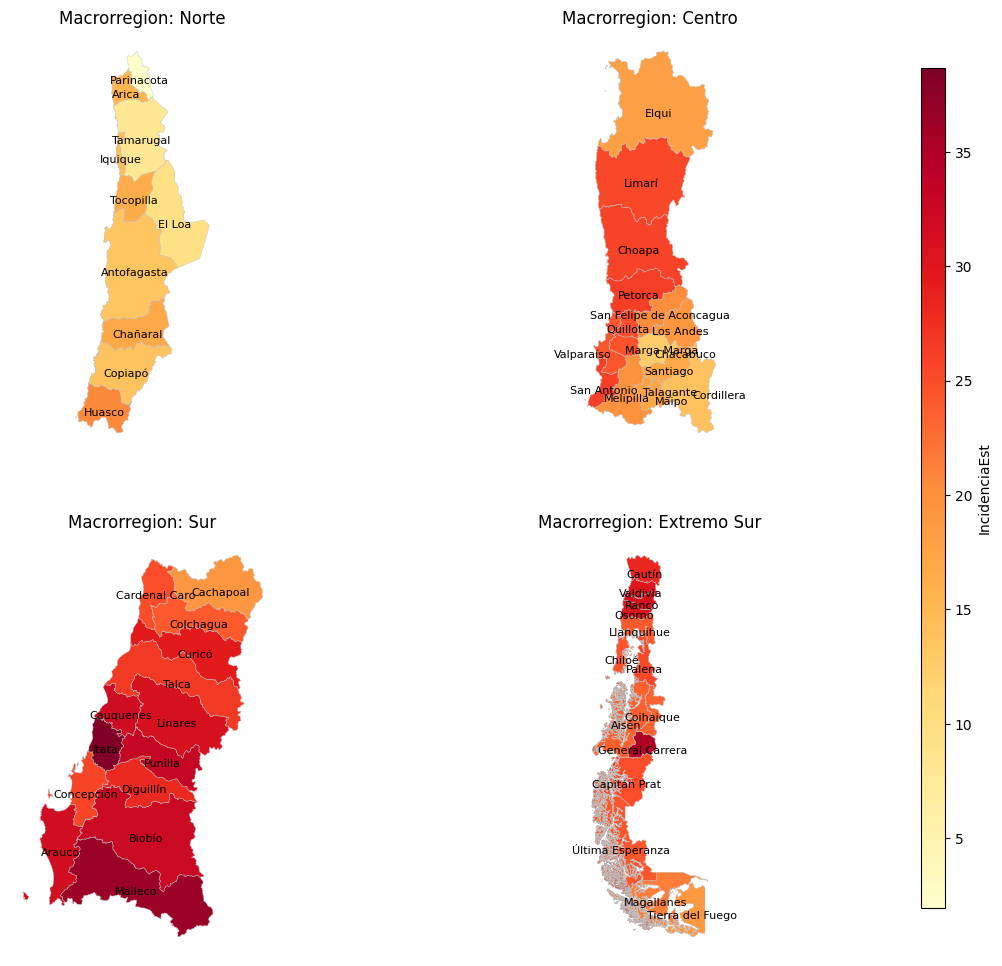

In [23]:
#@title Figura 2: Heatmap Provincias
mapa_incidencia(incMaps, prov_gpd, colorDim='IncidenciaEst', colorScale='YlOrRd', subplot_col='Macrorregion', nombres_provincias=True, grilla2x2=True)

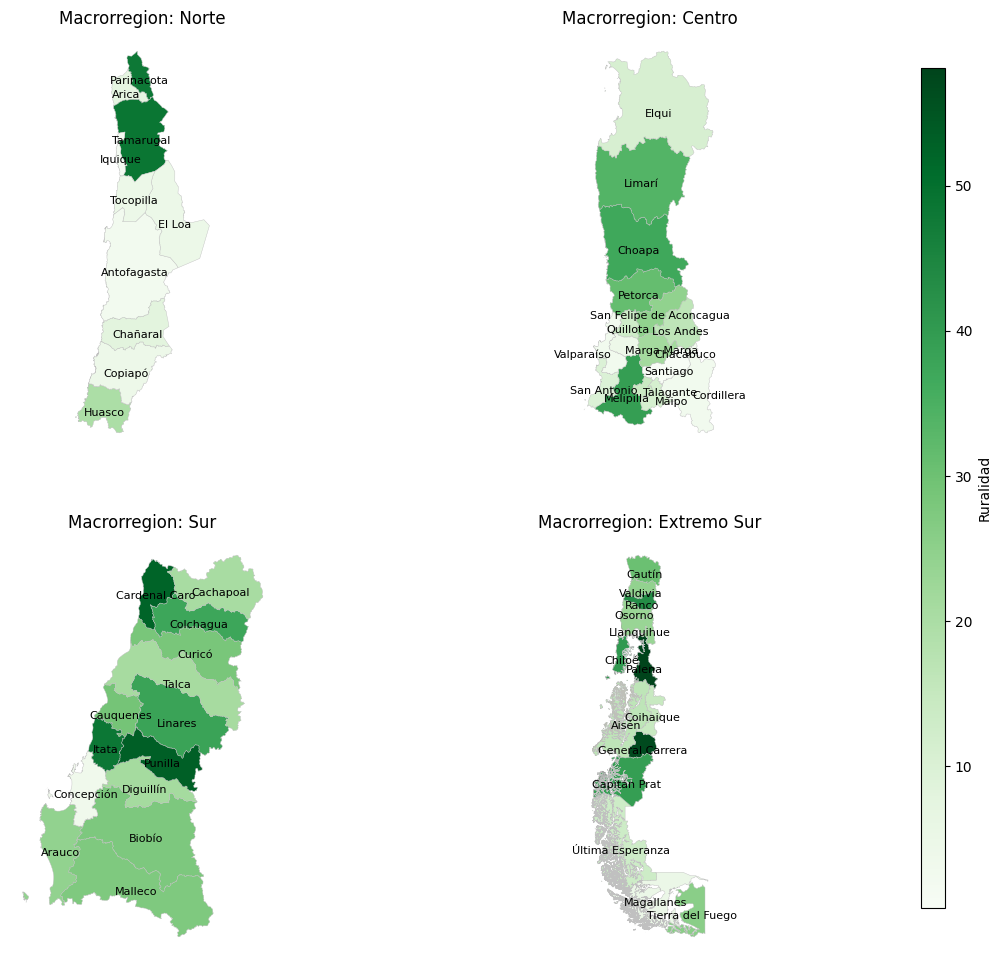

In [24]:
#@title Material Sup 6
mapa_incidencia(incMaps, prov_gpd, colorDim='Ruralidad', colorScale='Greens', subplot_col='Macrorregion', nombres_provincias=True, grilla2x2=True)

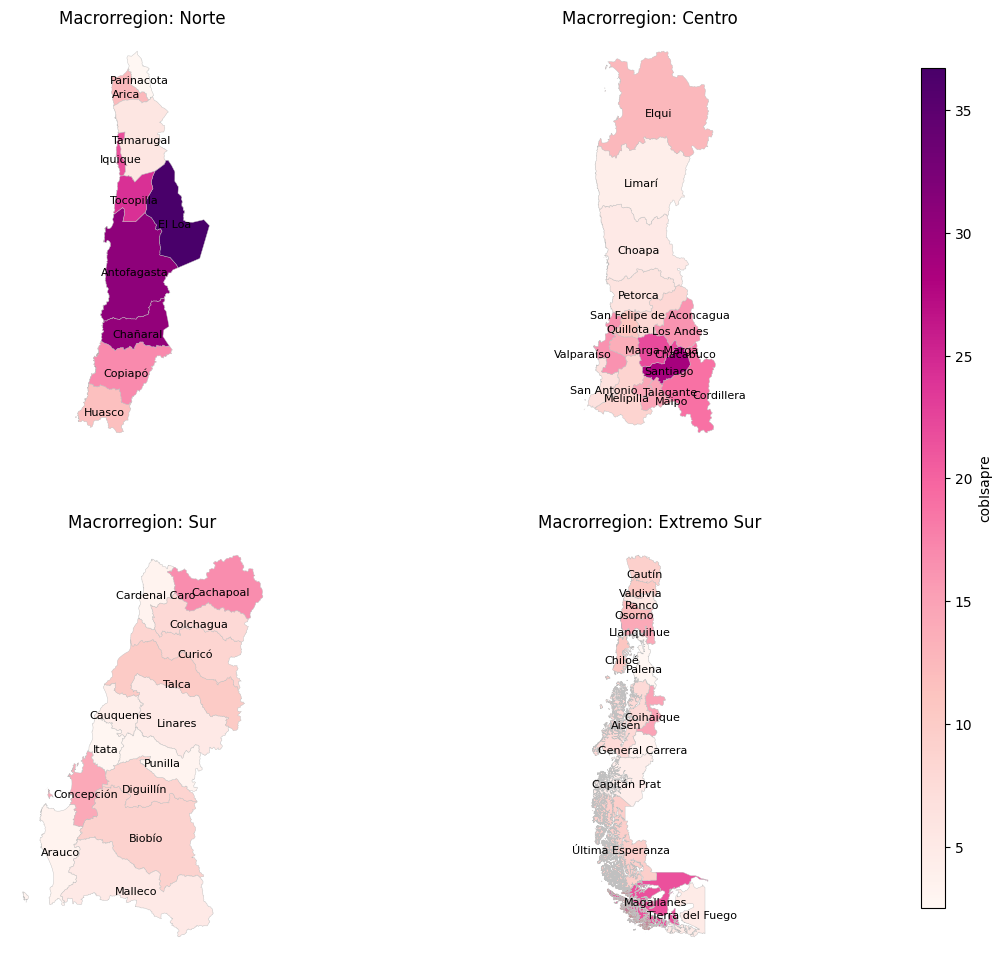

In [25]:
mapa_incidencia(incMaps, prov_gpd, colorDim='cobIsapre', colorScale='RdPu', subplot_col='Macrorregion', nombres_provincias=True, grilla2x2=True)

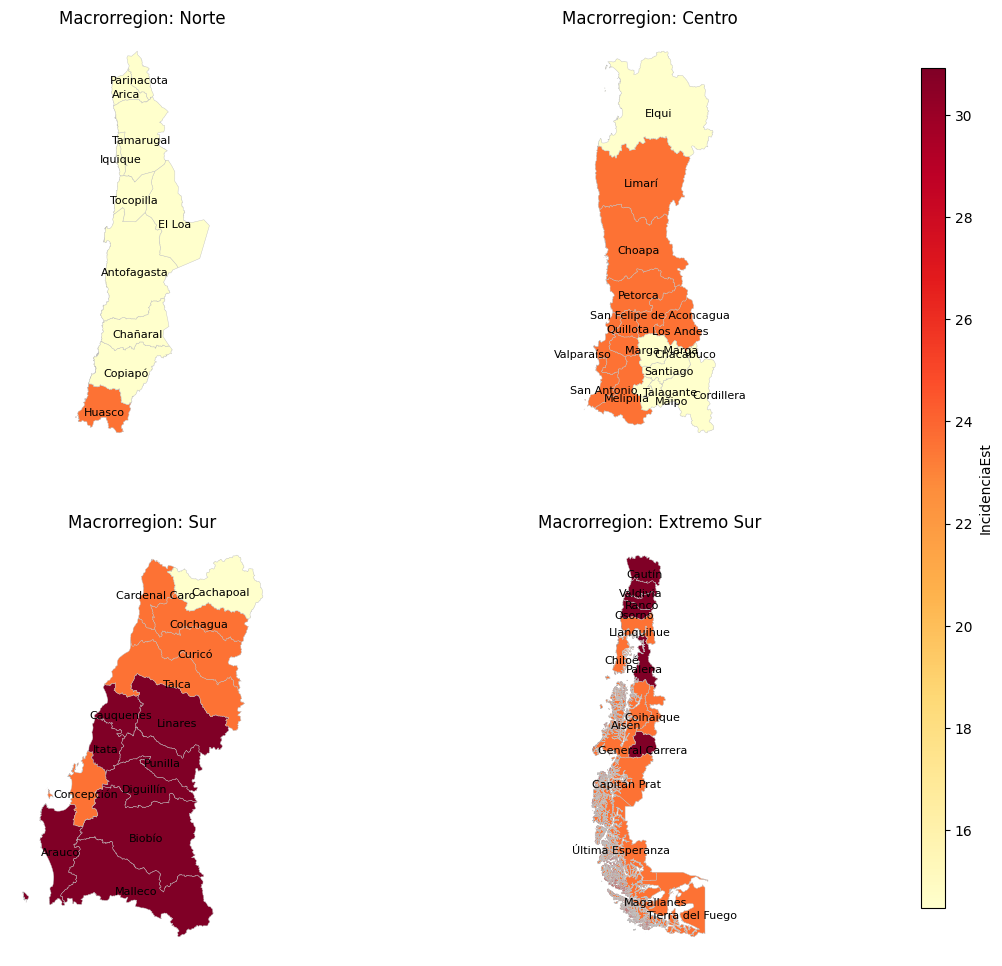

In [26]:
#@title Figura 5: Clusters

mapa_incidencia(agregar_dimensiones_mapas(calcular_incidencia_provincias(inc[inc.Metodo=='RIMcl'].copy(), niveles=['Provincia']).
                                          drop(columns='IncidenciaEst'),
                                          clusters),
                prov_gpd,
                colorDim='IncidenciaEst',
                colorScale='YlOrRd',
                subplot_col='Macrorregion',
                nombres_provincias=True,
                grilla2x2=True)

### Comparacion periodos

In [27]:
def data_clusters_periodos(incidencia_clusters=True):

  # Cargar estimaciones de incidencia
  df = calcular_incidencia_provincias(inc[inc.Metodo=='RIMcl'].copy(), niveles=['Provincia'])
  df.Periodo = df.Periodo.astype(int)

  if not incidencia_clusters:
    return df[lambda x: x.Periodo.isin([2004,2023])][['Periodo','Provincia','IncidenciaEst']]

  # Calcular incidencia por cluster-periodo
  inc_clusters = (df.
                  merge(clusters[['Provincia','Cluster']], on='Provincia').
                  groupby(['Periodo','Cluster'])[['Casos','Poblacion']].sum().reset_index())
  inc_clusters['IncidenciaEst'] = inc_clusters.Casos / inc_clusters.Poblacion * HABS

  # Primer y último periodo
  inc_clusters = (inc_clusters.merge(clusters[['Provincia','Cluster']], on='Cluster')
                              [lambda x: x.Periodo.isin([2004,2023])][['Periodo','Provincia','IncidenciaEst']])

  return inc_clusters

In [28]:
#@title Visual Abstract

def plot_incidence_maps_by_period(data, geo_data, color_dim='IncidenciaEst', color_scale='YlOrRd', vmax=None, nombres_provincias=False, save_path=None):

    # Merge incidence data with geographical data
    merged_data = geo_data.merge(data[data.Provincia!=52], on='Provincia', how='inner')   # Filtrar isla de pascua

    unique_periods = sorted(merged_data['Periodo'].unique())
    n_periods = len(unique_periods)
    n_cols = 3 # Aim for 3 columns per row for better readability
    n_rows = (n_periods + n_cols - 1) // n_cols

    # Generar grilla para subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 6), squeeze=False)
    axes = axes.flatten()

    # Calculate vmax and vmin across all periods for consistent color scale
    if vmax is None:
        vmax = merged_data[color_dim].max()
    vmin = merged_data[color_dim].min()

    for i, period in enumerate(unique_periods):
        ax = axes[i]
        period_data = merged_data[merged_data['Periodo'] == period]

        period_data.plot(column=color_dim, cmap=color_scale, legend=False, edgecolor='silver', linewidth=0.3, vmax=vmax, vmin=vmin, ax=ax)
        ax.set_title('2003-2005' if period==2004 else '2022-2024')
        ax.set_axis_off()

        # Add province names as text annotations if requested
        if nombres_provincias:
            for x, y, label in zip(period_data.centroid_x,
                                   period_data.centroid_y,
                                   period_data.PROVINCIA):
                ax.text(x, y, label, fontsize=6, ha='center', va='center')

    # Hide any unused subplots if n_periods is not a perfect multiple of n_cols
    for j in range(n_periods, len(axes)): fig.delaxes(axes[j])

    # Add a single colorbar for the entire figure
    cbar_ax = fig.add_axes([0.7, 0.15, 0.02, 0.7]) # [*left*, bottom, width, height]
    sm = plt.cm.ScalarMappable(cmap=color_scale, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    fig.colorbar(sm, cax=cbar_ax, label=color_dim)

    plt.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust layout to make space for colorbar
    plt.show()

    if save_path:
        fig.savefig(save_path, format='svg')

/tmp/ipython-input-1552442790.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust layout to make space for colorbar


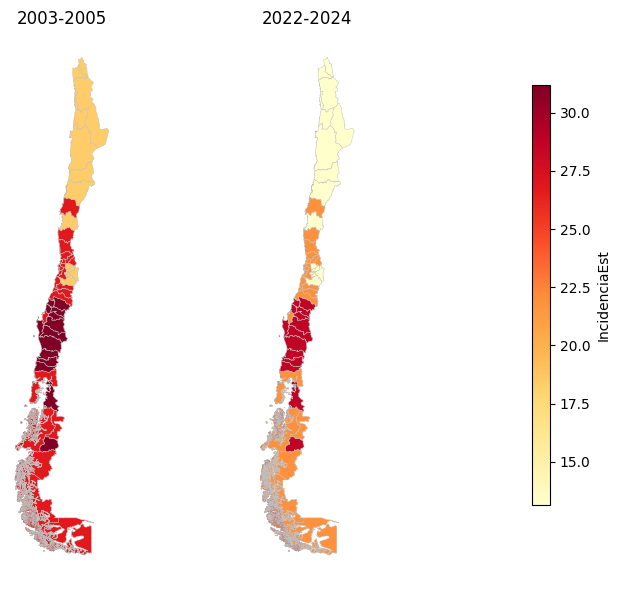

In [29]:
path_output = '/content/output/'
# Crear carpeta output
if not os.path.exists(path_output): os.makedirs(path_output)

output_filename = os.path.join(path_output, 'mapa_incidencia_periodos.svg')

plot_incidence_maps_by_period(data_clusters_periodos(), prov_gpd, color_dim='IncidenciaEst', color_scale='YlOrRd', nombres_provincias=False, save_path=output_filename)

/tmp/ipython-input-1552442790.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust layout to make space for colorbar


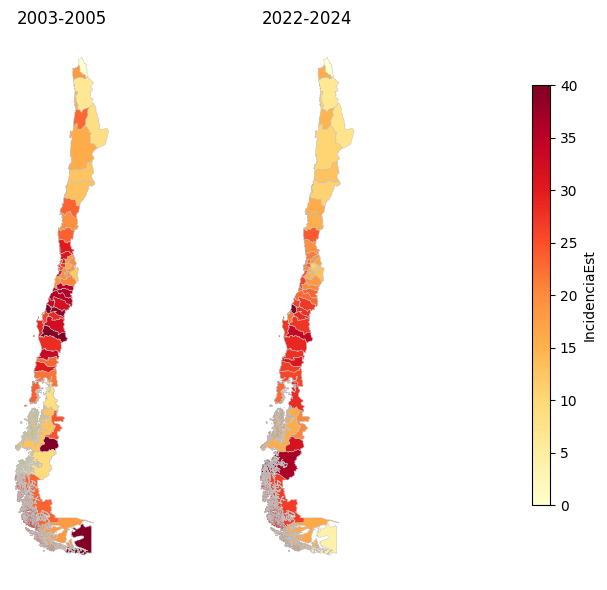

In [30]:
plot_incidence_maps_by_period(data_clusters_periodos(incidencia_clusters=False),
                              prov_gpd,
                              vmax=40,
                              color_dim='IncidenciaEst', color_scale='YlOrRd', nombres_provincias=False)

# 📈Series de tiempo de Incidencia
Incidencia estandarizada por año, estratificada por sexo, status urbano/rural, cobertura Fonasa/Isapre. Metodología de estandarización de incidencia: https://www.cdc.gov/nchs/hus/sources-definitions/age-adjustment.htm.


In [31]:
def cubo_incidencia_provincias_estratificada(pobEstandar=True, metodo='RIMcl'):

  # Cargar cubo y agregar periodos
  metrics = (cubo[cubo.Categoria=='C16'].
             merge(periodos[periodos.Provincia==1000][['Año','Periodo']], on='Año').
            # suma años-personas de población rural, Fonasa e Isapre
             groupby(['RangoEdad4080','Sexo','Provincia','Periodo','MedianaRangoEdad4080'])[['PoblacionRural','A','B','C','D','Isapre']].sum().reset_index())

  # A predicciones de incidencia agregar métricas y pob estandar
  df = (inc[inc.Metodo==metodo].copy().
        merge(poblacion_estandar, on='RangoEdad4080', how='left').
        merge(metrics, on=['Provincia','Sexo','RangoEdad4080','Periodo'], how='left').
        drop(columns=['Categoria','Ratio','RatioEst','Metodo','Escenario','Grupo','IncidenciaObs']))

  return df

incProvinciasEstratificada = cubo_incidencia_provincias_estratificada(metodo='RIMcl')
incProvinciasEstratificada

,RangoEdad4080,Nombre Provincia,Provincia,Sexo,Periodo,IncidenciaEst,Poblacion,Casos,PoblacionOMS,MedianaRangoEdad4080,PoblacionRural,A,B,C,D,Isapre
0,"[0, 40)",Iquique,11,Hombre,2004,0.000000,252600,0.000000,655070,20.0,3105,36074,25087,28736,30336,108851
1,"[0, 40)",Tamarugal,14,Hombre,2004,0.000000,19639,0.000000,655070,20.0,10907,4325,1722,1190,1892,2087
2,"[0, 40)",Antofagasta,21,Hombre,2004,0.512005,350440,1.794272,655070,20.0,8391,40458,31157,33039,29971,193563
3,"[0, 40)",El Loa,22,Hombre,2004,1.107623,161993,1.794272,655070,20.0,6059,14234,14051,16480,19416,122093
4,"[0, 40)",Tocopilla,23,Hombre,2004,0.000000,34584,0.000000,655070,20.0,1236,1252,1461,1111,352,20742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4615,"[80, 120)",Arica,151,Mujer,2023,91.826303,13375,12.281768,15445,90.0,1061,336,10422,784,1140,410
4616,"[80, 120)",Parinacota,152,Mujer,2023,0.000000,249,0.000000,15445,90.0,93,7,42,0,0,0
4617,"[80, 120)",Diguillín,161,Mujer,2023,134.614835,25090,33.774862,15445,90.0,5098,111,19548,1160,1214,463
4618,"[80, 120)",Itata,162,Mujer,2023,95.759793,5344,5.117403,15445,90.0,2412,15,3640,122,139,25


In [32]:
def serie_temporal_estrato(estrato, pobEstandar=False):

  cuboInc = cubo_incidencia_provincias_estratificada(pobEstandar=pobEstandar)

  dimensiones = ['Provincia','Nombre Provincia','Periodo','Sexo'] # dimensiones comunes para todas las series
  metricas = ['Casos','Poblacion','PoblacionOMS']

  # Proyectar casos por provincia en población real
  cuboInc['Casos'] = cuboInc['IncidenciaEst']/HABS * cuboInc['Poblacion']

  # Agrupar al nivel del estrato
  match estrato:

    case 'RangoEdad4080':

      # Incidencia nacional: tasa cruda equivale a la estandarizada pues ambas están estratificadas por edad
      # Casos por sexo-edad a nivel nacional
      total = cuboInc.groupby(['Periodo','Sexo',estrato], observed=True)[['Casos','Poblacion']].sum().reset_index()
      # Incidencia por sexo-edad
      total['Incidencia'] = total.Casos / total.Poblacion * HABS

      # Incidencia por Provincia
      df = cuboInc.groupby(dimensiones+[estrato])[['Casos','Poblacion']].sum().reset_index()
      df['Incidencia'] = df.Casos / df.Poblacion * HABS

    case 'nombreCluster':

      # Agregar datos clusters
      df = (cuboInc.groupby(dimensiones+['RangoEdad4080'])[metricas].agg({'Casos':'sum','Poblacion':'sum','PoblacionOMS':'first'}).reset_index().
            merge(clusters, on='Provincia'))

      if pobEstandar:
        # Incidencia nacional
        # Casos por sexo-edad a nivel nacional
        total = df.groupby(['Periodo','Sexo','RangoEdad4080',estrato], observed=True).agg({'Casos':'sum','Poblacion':'sum','PoblacionOMS':'first'}).reset_index()
        # Incidencia cruda por cluster-sexo-edad
        total['Incidencia'] = total.Casos / total.Poblacion * HABS
        # Casos en población OMS
        total['Casos'] = total.PoblacionOMS * total.Incidencia / HABS
        # Agrupar casos OMS por cluster-sexo
        total = total.groupby(['Periodo','Sexo',estrato])[['Casos','PoblacionOMS']].sum().reset_index()
        # Incidencia estandar por cluster-sexo
        total['Incidencia'] = total.Casos / total.PoblacionOMS * HABS

        # Incidencia por provincia
        # Incidencia cruda por cluster-sexo-edad
        df['Incidencia'] = df.Casos / df.Poblacion * HABS
        # Casos por sexo-edad en poblacion OMS
        df['Casos'] = df.PoblacionOMS * df.Incidencia / HABS
        # Agrupar casos por cluster-sexo
        df = df.groupby(dimensiones+[estrato])[['Casos','PoblacionOMS']].sum().reset_index()
        # Incidencia estandar
        df['Incidencia'] = df.Casos / df.PoblacionOMS * HABS

      else:
        # Casos por sexo-edad a nivel nacional
        total = df.groupby(['Periodo','Sexo',estrato], observed=True).agg({'Casos':'sum','Poblacion':'sum'}).reset_index()
        # Incidencia cruda por cluster-sexo
        total['Incidencia'] = total.Casos / total.Poblacion * HABS

        # Incidencia por provincia
        # Agrupar casos por cluster-sexo
        df = df.groupby(dimensiones+[estrato])[['Casos','Poblacion']].sum().reset_index()
        # Incidencia cruda
        df['Incidencia'] = df.Casos / df.Poblacion * HABS

  total.insert(0,'Nombre Provincia','Nacional')
  df = pd.concat([df, total])

  # Ordenar clusters
  if estrato=='nombreCluster':
    df.sort_values(by=['Periodo','nombreCluster'],
                   key=lambda x: x.map({'Bajo riesgo':0,'Riesgo medio':1,'Alto riesgo':2,'Muy alto riesgo':3}),
                   inplace=True)

  return df

serie_temporal_estrato(estrato='nombreCluster', pobEstandar=True)

,Provincia,Nombre Provincia,Periodo,Sexo,nombreCluster,Casos,PoblacionOMS,Incidencia
0,11.0,Iquique,2004,Hombre,Bajo riesgo,336.772499,1000000,33.677250
1,11.0,Iquique,2004,Mujer,Bajo riesgo,110.898620,1000000,11.089862
2,11.0,Iquique,2007,Hombre,Bajo riesgo,238.868829,1000000,23.886883
3,11.0,Iquique,2007,Mujer,Bajo riesgo,134.237784,1000000,13.423778
4,11.0,Iquique,2011,Hombre,Bajo riesgo,316.172618,1000000,31.617262
...,...,...,...,...,...,...,...,...
27,NaN,Nacional,2017,Mujer,Alto riesgo,118.522915,1000000,11.852292
30,NaN,Nacional,2020,Hombre,Alto riesgo,274.797299,1000000,27.479730
33,NaN,Nacional,2020,Mujer,Alto riesgo,100.548097,1000000,10.054810
36,NaN,Nacional,2023,Hombre,Alto riesgo,244.934917,1000000,24.493492


Period   2004  2007  2011  2014  2017  2020  2023
Sex                                              
Females  13.3  11.8  11.4  10.3   9.0   7.9   7.3
Males    36.0  32.8  30.8  27.0  23.8  20.3  17.9


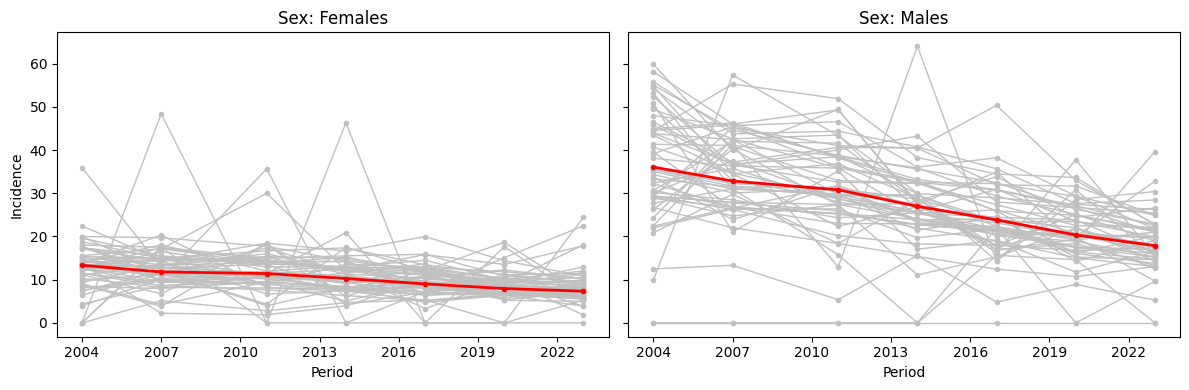

In [33]:
#@title Figura 3a: Serie Sexo

def plot_serie_incidencia_sexo(pobEstandar=False, log_y=False):

  # Cargar datos
  data = (serie_temporal_estrato('RangoEdad4080', pobEstandar=pobEstandar).
          merge(poblacion_estandar, on='RangoEdad4080'))
  if pobEstandar:
    data['Casos'] = data.Incidencia/HABS * data.PoblacionOMS
    data['Poblacion'] = data.PoblacionOMS
  data = data.groupby(['Nombre Provincia','Periodo','Sexo'])[['Casos','Poblacion']].sum().reset_index()
  data['Incidencia'] = data.Casos / data.Poblacion * HABS
  data['Periodo'] = data.Periodo.astype(int)
  # Change to names in english
  data.rename(columns={'Sexo':'Sex','Periodo':'Period'}, inplace=True)
  data['Sex'] = data.Sex.map({'Hombre':'Males','Mujer':'Females'})

  print(data[data['Nombre Provincia']=='Nacional'].pivot(index=['Sex'], columns='Period', values='Incidencia').round(1))

  # anular log(0) para una visualización más limpia
  if log_y: data.loc[data.Incidencia==0,'Incidencia'] = pd.NA

  # Parámetros subplots
  unique_facets = ['Females','Males']
  unique_provs = data['Nombre Provincia'].unique()
  # drop Nacional and append to the end
  unique_provs = np.append(unique_provs[unique_provs!='Nacional'], 'Nacional')
  unique_provs = unique_provs
  n_cols = len(unique_facets)

  # Generar subplots
  fig, axes = plt.subplots(1, n_cols, squeeze=True, sharey=True, figsize=(n_cols*6, 4))

  for col_i, facet_value in enumerate(unique_facets):
      ax = axes[col_i]
      subset_data = data[data['Sex'] == facet_value]

      for prov in unique_provs:
          prov_data = subset_data[subset_data['Nombre Provincia'] == prov]
          ax.plot(prov_data['Period'].astype(int), prov_data['Incidencia'], marker='.',
                  color = ('red' if prov == 'Nacional' else 'silver'),
                  linewidth = (2 if prov == 'Nacional' else 1))

      ax.set_title(f'Sex: {facet_value}') # Add title for each subplot
      ax.set_xlabel('Period')
      ax.set_ylabel('Incidence')
      if log_y: ax.set_yscale('log')
      # Ensure x-axis labels are integers
      ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
      # Add Sexo label only for the first column
      ax.set_ylabel('Incidence' if col_i == 0 else '')

  plt.subplots_adjust(wspace=0.02, hspace=0.05)
  plt.tight_layout()

  plt.show()

plot_serie_incidencia_sexo(pobEstandar=True)

In [34]:
def plot_serie_incidencia(estrato, pobEstandar=False, log_y=False):

  # Cargar datos
  data = (serie_temporal_estrato(estrato, pobEstandar=pobEstandar).
  # English labels
          rename(columns={'Sexo':'Sex', 'Periodo':'Period'}))
  data['Sex'] = data.Sex.map({'Hombre':'Males','Mujer':'Females'})
  if estrato=='nombreCluster':
    data['nombreCluster'] = data.nombreCluster.map({'Bajo riesgo':'Low risk','Riesgo medio':'Medium risk','Alto riesgo':'High risk'})


  print(data[data['Nombre Provincia']=='Nacional'].pivot(index=['Sex',estrato], columns='Period', values='Incidencia').round(1))

  # anular log(0)
  if log_y: data.loc[data.Incidencia==0,'Incidencia'] = pd.NA

  # Parámetros subplots
  unique_facets = data[estrato].unique()
  unique_sexos = data['Sex'].unique()
  unique_provs = data['Nombre Provincia'].unique()
  # drop Nacional and append to the end
  unique_provs = np.append(unique_provs[unique_provs!='Nacional'], 'Nacional')
  unique_provs = unique_provs
  n_cols = len(unique_facets)
  n_rows = len(unique_sexos)

  # Generar subplots
  fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows * 3), squeeze=True, sharey=True)

  for row_i, sexo in enumerate(unique_sexos):
      for col_i, facet_value in enumerate(unique_facets):
          ax = axes[row_i, col_i]
          subset_data = data[(data[estrato] == facet_value) & (data.Sex == sexo)]

          for prov in unique_provs:
              prov_data = subset_data[subset_data['Nombre Provincia'] == prov]
              ax.plot(prov_data['Period'], prov_data['Incidencia'], marker='.',
                      color = ('red' if prov == 'Nacional' else 'silver'),
                      linewidth = (2 if prov == 'Nacional' else 1))

          # Add estrato title only for the first row
          if row_i == 0: ax.set_title(f'{facet_value}')
          # Remove x-axis tick labels for first row
          ax.tick_params(axis='x', which='both', labelbottom=(False if row_i==0 else True))
          # Add Sexo label only for the first column
          ax.set_ylabel(f'{sexo}' if col_i == 0 else '')

          if log_y: ax.set_yscale('log')
  plt.subplots_adjust(wspace=0.02, hspace=0.05)
  plt.tight_layout()

  plt.show()

Period                  2004   2007   2011   2014   2017   2020   2023
Sex     RangoEdad4080                                                 
Females [0, 40)          1.0    0.7    0.9    1.0    0.8    0.9    0.8
        [40, 50)         7.3    6.5    6.8    6.3    6.5    5.1    5.0
        [50, 60)        16.6   15.4   14.7   14.4   13.0   11.3   11.5
        [60, 70)        46.0   39.6   40.4   33.2   28.6   23.4   23.8
        [70, 80)        98.5   95.6   88.5   82.4   67.0   61.1   51.3
        [80, 120)      216.9  179.3  163.0  138.0  128.9  112.0   99.4
Males   [0, 40)          1.0    0.9    0.9    1.0    0.7    0.9    0.8
        [40, 50)        15.5   14.6   14.1   11.2   10.2    8.3    7.2
        [50, 60)        53.4   45.7   42.5   37.7   35.1   30.1   24.4
        [60, 70)       148.5  141.6  123.9  102.7   90.7   76.0   71.6
        [70, 80)       298.3  280.6  276.5  243.7  204.6  177.3  143.1
        [80, 120)      458.6  385.6  364.8  335.8  319.9  261.9  253.8


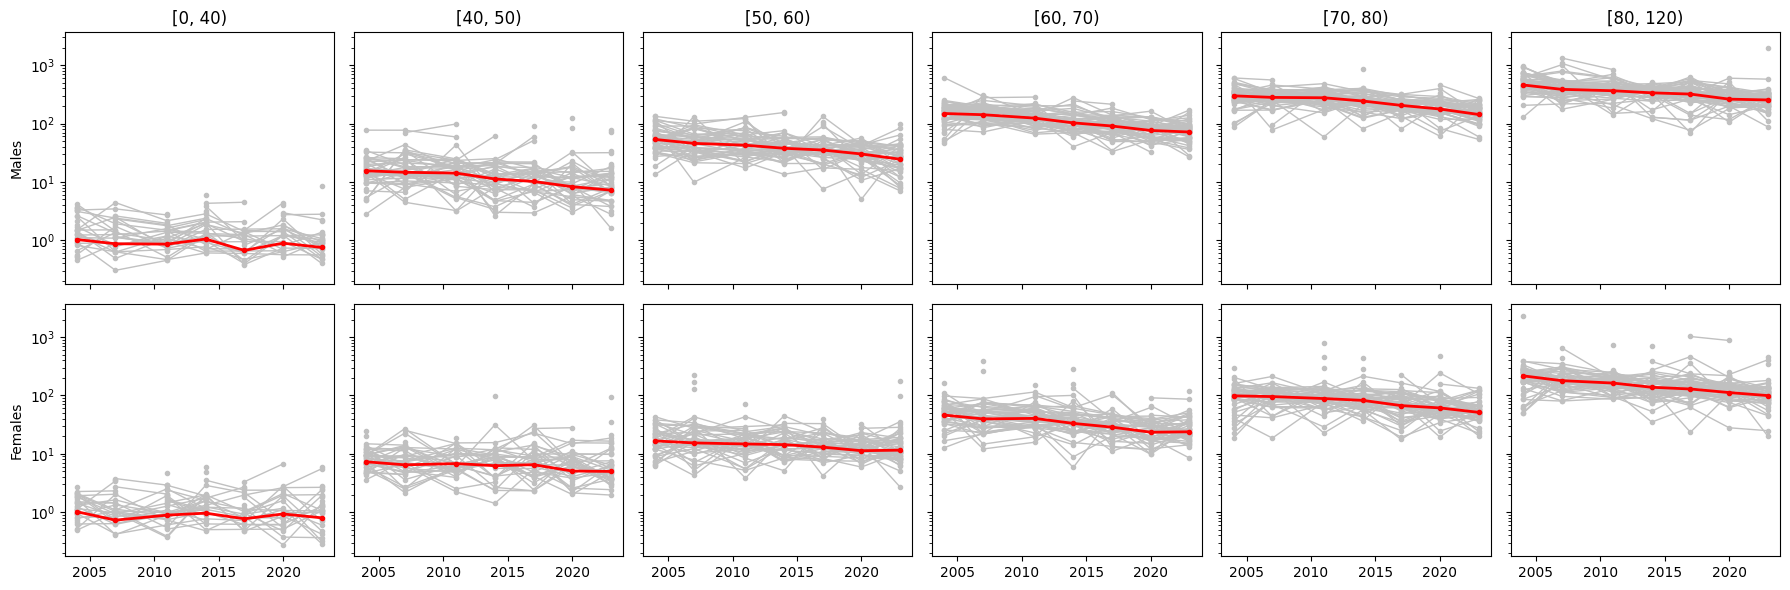

In [35]:
# @title Figura 3b: Serie Sexo - Edad

# Incidencia cruda
plot_serie_incidencia(estrato='RangoEdad4080', pobEstandar=False, log_y=True)

Period                 2004  2007  2011  2014  2017  2020  2023
Sex     nombreCluster                                          
Females High risk      16.4  15.5  14.6  13.3  11.9  10.1  10.2
        Low risk       11.7   9.8   9.7   8.5   7.4   6.8   5.9
        Medium risk    14.3  13.1  12.5  11.5  10.0   8.6   8.1
Males   High risk      45.2  42.7  40.7  34.1  31.5  27.5  24.5
        Low risk       30.0  27.8  25.8  22.6  19.9  16.5  14.3
        Medium risk    39.8  34.6  32.4  29.5  25.4  22.2  19.6


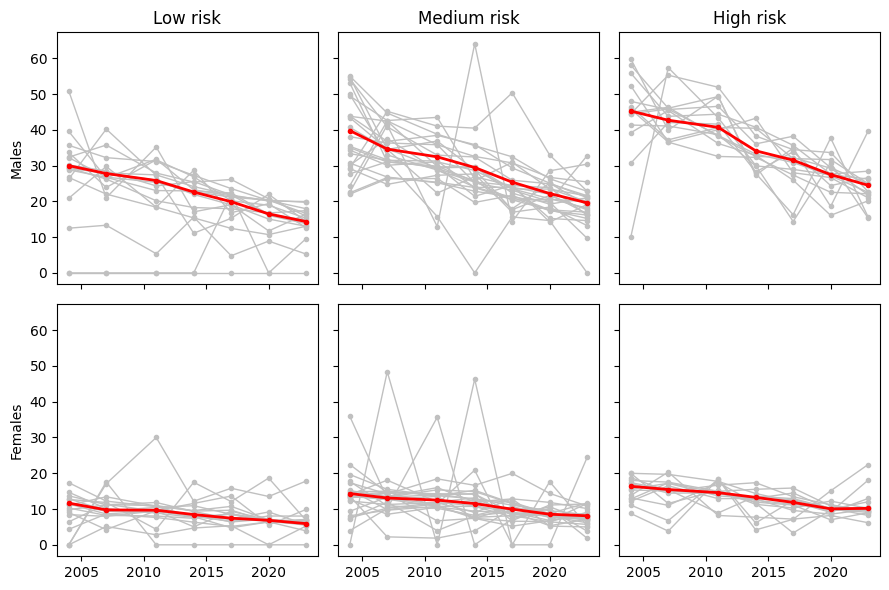

In [36]:
# @title Figura 6: Serie Clusters
# Incidencia estandarizada
plot_serie_incidencia(estrato='nombreCluster', pobEstandar=True) #, log_y=True

Period                 2004  2007  2011  2014  2017  2020  2023
Sex     nombreCluster                                          
Females High risk      18.9  19.3  19.8  19.6  18.9  17.1  18.3
        Low risk       12.9  11.6  12.3  11.5  10.5   9.8   9.1
        Medium risk    16.9  16.6  17.1  16.7  15.7  14.4  14.2
Males   High risk      43.7  44.5  46.5  42.8  43.0  40.5  39.5
        Low risk       24.1  23.9  24.1  22.9  21.5  18.5  17.3
        Medium risk    36.7  34.6  35.4  35.2  32.9  30.9  29.9


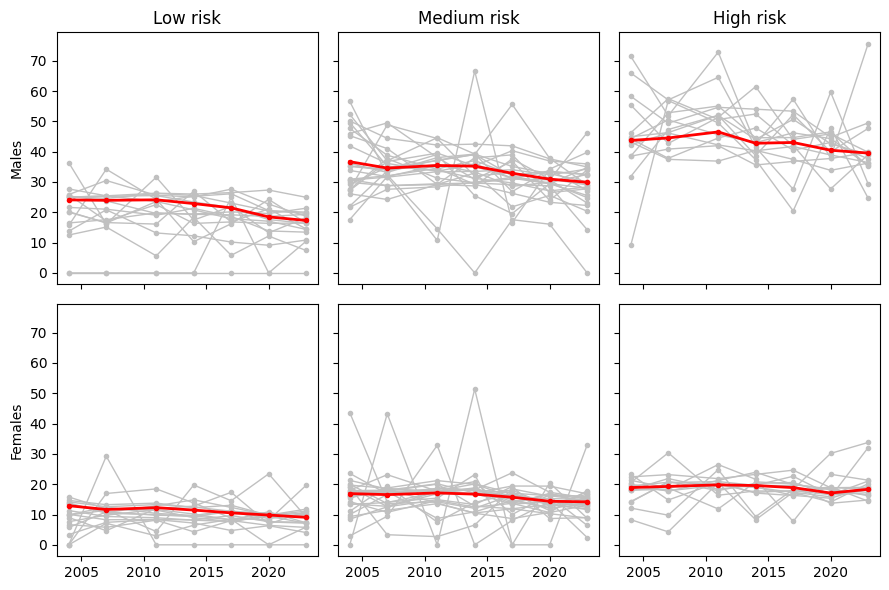

In [37]:
#@title Material Sup 7
# Incidencia cruda
plot_serie_incidencia(estrato='nombreCluster', pobEstandar=False)

## Modelos Mixtos

In [39]:
#@title Material Sup 5a: Modelo Sexo-Edad

def regresion_mixta_incidencia2(data):

  # Transformar outcome
  data=data[data.IncidenciaEst>0]
  data['LogIncidencia'] = np.log(data.IncidenciaEst)

  # Preparar Covariables
  data['RangoEdad4080'] = data['RangoEdad4080'].astype('category')
  data['SexoFemenino'] = (data['Sexo']=='Mujer').astype(int)
  data['SexoMasculino'] = (data['Sexo']=='Hombre').astype(int)
  data['Ruralidad'] = data.PoblacionRural/data.Poblacion
  for tramo in ['A','B','C','D','Isapre']:
    data['cob'+tramo] = data[tramo] / data.Poblacion

  # Define the mixed-effects model using statsmodels mixedlm
  mixed_model = smf.mixedlm("LogIncidencia ~ 1 + RangoEdad4080 + SexoMasculino + Periodo:SexoMasculino:RangoEdad4080 + Periodo:SexoFemenino:RangoEdad4080",
                            data,
                            groups='Provincia',
                            re_formula='1')

  # Fit the model
  mixed_results = mixed_model.fit()
  print(mixed_results.summary())
  return mixed_results

modelo2 = regresion_mixta_incidencia2(incProvinciasEstratificada.copy())

                          Mixed Linear Model Regression Results
Model:                       MixedLM           Dependent Variable:           LogIncidencia
No. Observations:            3710              Method:                       REML         
No. Groups:                  55                Scale:                        0.2005       
Min. group size:             1                 Log-Likelihood:               -2486.5933   
Max. group size:             84                Converged:                    Yes          
Mean group size:             67.5                                                         
------------------------------------------------------------------------------------------
                                               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------
Intercept                                       7.778    7.467   1.042 0.298 -6.857 22.413
RangoEdad4080[T.[40, 50)] 

In [40]:
#@title Material Sup 5b: Modelo Covariables

def regresion_mixta_incidencia(data):

  # Transformar outcome (log incidencia cruda)
  data=data[data.IncidenciaEst>0]
  data['LogIncidencia'] = np.log(data.IncidenciaEst)

  # Preparar Covariables
  data['Ruralidad'] = data.PoblacionRural/data.Poblacion * 100
  for tramo in ['A','B','C','D','Isapre']:
    data['cob'+tramo] = data[tramo] / data.Poblacion * 100
  data['RangoEdad4080'] = data['RangoEdad4080'].astype('category')
  data['SexoMasculino'] = (data['Sexo']=='Hombre').astype(int)

  # Define the mixed-effects model using statsmodels mixedlm
  mixed_model = smf.mixedlm("LogIncidencia ~ 1 + Periodo + SexoMasculino + RangoEdad4080 + Ruralidad + cobIsapre", #+ cobA + cobB + cobC + cobD + Pandemia2020+ Periodo:SexoMasculino
                            data,
                            groups='Provincia',
                            re_formula='1')

  # Fit the model
  mixed_results = mixed_model.fit()
  print(mixed_results.summary())
  return mixed_results

# modelo con incidencia cruda
modelo = regresion_mixta_incidencia(incProvinciasEstratificada.copy())

# Coeficientes exponenciados
(np.exp(modelo.params[['SexoMasculino',
                        'RangoEdad4080[T.[40, 50)]','RangoEdad4080[T.[50, 60)]','RangoEdad4080[T.[60, 70)]','RangoEdad4080[T.[70, 80)]','RangoEdad4080[T.[80, 120)]',
                        'Periodo',
                        'Ruralidad','cobIsapre']])-1).round(3)*100

                Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    LogIncidencia
No. Observations:      3710       Method:                REML         
No. Groups:            55         Scale:                 0.2295       
Min. group size:       1          Log-Likelihood:        -2665.5574   
Max. group size:       84         Converged:             Yes          
Mean group size:       67.5                                           
----------------------------------------------------------------------
                           Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                  55.594    2.678  20.760 0.000 50.345 60.843
RangoEdad4080[T.[40, 50)]   2.046    0.031  65.750 0.000  1.985  2.107
RangoEdad4080[T.[50, 60)]   2.929    0.031  94.976 0.000  2.868  2.989
RangoEdad4080[T.[60, 70)]   3.825    0.031 121.523 0.000  3.764  3.887
RangoEdad4080[T.[70, 80

,0
SexoMasculino,124.2
"RangoEdad4080[T.[40, 50)]",673.4
"RangoEdad4080[T.[50, 60)]",1770.1
"RangoEdad4080[T.[60, 70)]",4484.4
"RangoEdad4080[T.[70, 80)]",9386.4
"RangoEdad4080[T.[80, 120)]",15636.0
Periodo,-2.7
Ruralidad,0.6
cobIsapre,-1.0


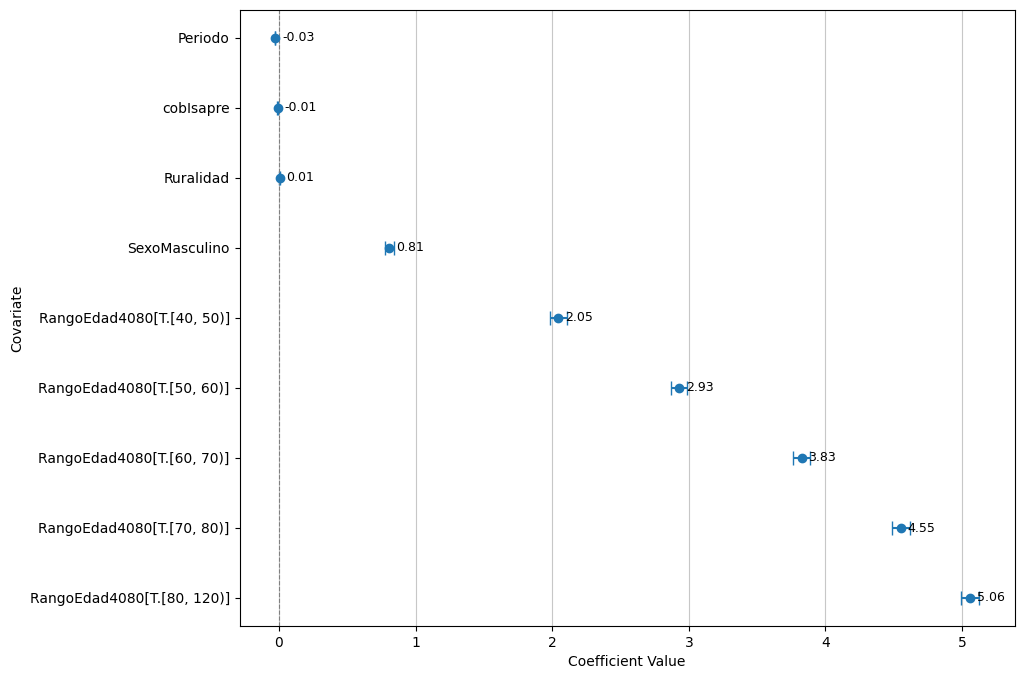

In [41]:
#@title Figura 4: Forest plots
# showing the effect sizes of covariates

def forest_plot(modelo, parametros, logScale=False, exponentiated=False):

  # Extract coefficients and standard errors from the model
  coefs = modelo.params[parametros]
  conf_int = modelo.conf_int().loc[coefs.index]

  # Create a DataFrame for plotting
  plot_data = pd.DataFrame({'Coefficient': coefs.values,
                            'Lower CI': conf_int[0].values,
                            'Upper CI': conf_int[1].values,
                            'Coefficient_Index': coefs.index}) # Store index for plotting

  # Sort data by percentage change for better visualization
  plot_data = plot_data.sort_values(by='Coefficient', ascending=False)

  # Create the forest plot
  plt.figure(figsize=(10, 8))
  plt.errorbar(plot_data['Coefficient'],
               plot_data['Coefficient_Index'],
               xerr=[plot_data['Coefficient'] - plot_data['Lower CI'], plot_data['Upper CI'] - plot_data['Coefficient']],
               fmt='o', capsize=5)

  # Formatear plot
  plt.axvline(0, color='grey', linestyle='--', linewidth=0.8)
  # Add text annotations
  for i, row in plot_data.iterrows():
      plt.text(row['Coefficient'] + 0.05, row['Coefficient_Index'], f'{row["Coefficient"]:.2f}', ha='left', va='center', fontsize=9) # Annotate with actual coefficient values
  # Update axis labels
  plt.xlabel('Coefficient Value')
  plt.ylabel('Covariate')
  plt.grid(axis='x', alpha=0.7)
  if logScale: plt.xscale('symlog') # Set x-axis to symmetric log scale
  plt.show()

forest_plot(modelo, ['SexoMasculino',
                      'RangoEdad4080[T.[40, 50)]', 'RangoEdad4080[T.[50, 60)]','RangoEdad4080[T.[60, 70)]', 'RangoEdad4080[T.[70, 80)]','RangoEdad4080[T.[80, 120)]',
                      'Periodo', #'Pandemia2020','cobA','cobB', 'cobC','cobD',
                      'Ruralidad','cobIsapre'],
            logScale=False)

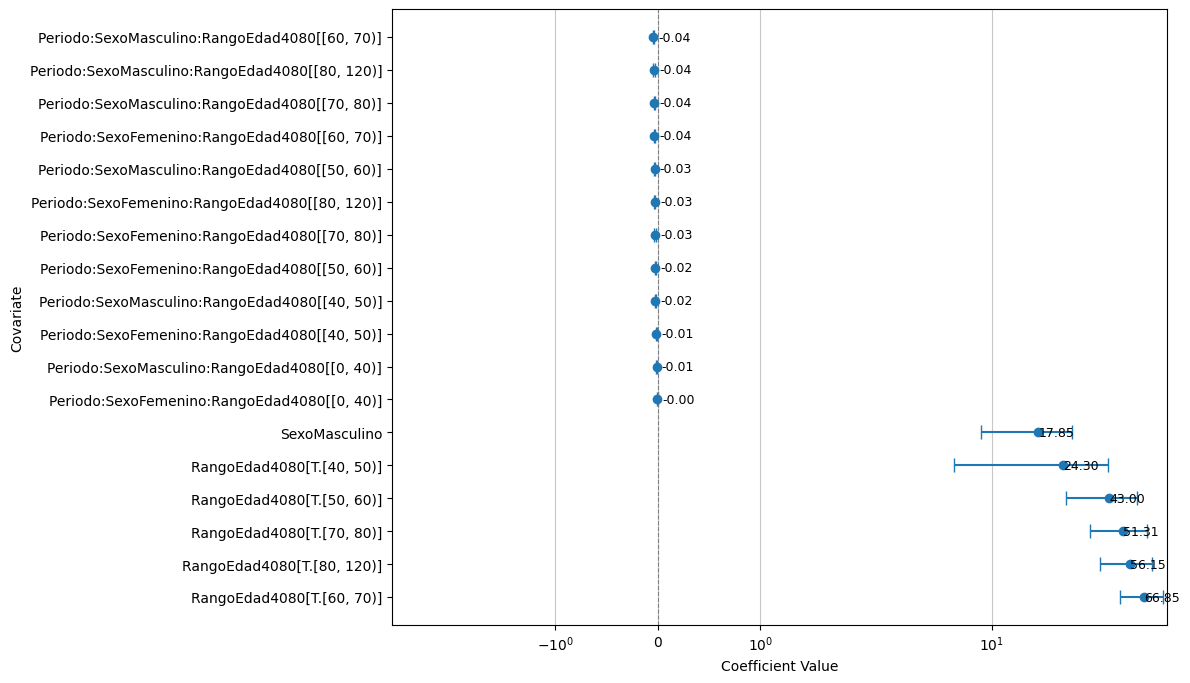

In [42]:
forest_plot(modelo2,
            [p for p in modelo2.params.index if p not in ['Intercept','Provincia Var']],
            logScale=True)